# Example usage of trainer class

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


## Define Dataset
Creating the dataset object and applzing transformations to the data.

In [3]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 1,
    tact_order = 10,
    tact_number=2, 
    rand_rotations=2
    
)
# set regenerate to true, if you run this after changes in dataconverter have been made
#dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


In [4]:
from data.reconstruction_dataset import *

csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


<Figure size 640x480 with 0 Axes>

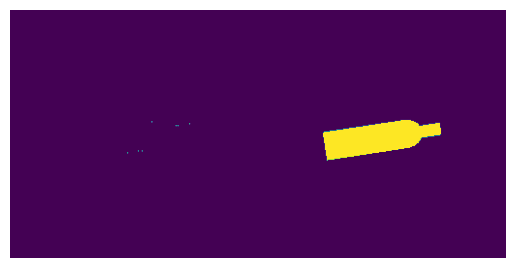

In [5]:
example_data = dataset[5]

plt.figure()
print(example_data['image'])
show_datapair(example_data['image'], example_data['label'])
plt.show()

## Choose Hyperparamters

Look into the file neural_nets.trainer to see which hyperparameters you can choose.
The seperation into tunable and non tunable hyperparameters is made, because this makes parameter searches with ray easier.


#### Non Tunable Hyperparameters


In [6]:
from neural_nets.trainer import NonTHparams


nt_h = NonTHparams()
nt_h.num_epochs = 50
nt_h.train_prop = 0.93 # set way to high to make validation period short and make testing this search easier

nt_h.print_log = True # to better see param search results
nt_h.log_train_period = 100
nt_h.log_val_freq = 5 #int(nt_h.train_prop*len(dataset)/f)-1 #set low to test this parameter search


#### Define Tunable Hyperparameters and parameter spaces for upgrade

The hyperparameters we want to tone have to be put into a list of possible values and that list into a dict, for the hyperparameter optimizer to do its job.

In [7]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

from neural_nets.trainer import THparams
from neural_nets.weight_inits import weight_init_kx
from neural_nets.models.unet import UNet2


from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

t_h = THparams()
t_h.batch_size = 16

t_h.model = UNet2
t_h.weight_init = weight_init_kx
t_h.depth = 5
t_h.channels = 64

t_h.lr = 1e-4
t_h.optimizer = optim.Adam
t_h.loss_func = nn.BCELoss()


image_resolution = dataset[0]['image'].shape[1]
max_unet_depth = int(np.log2(image_resolution))

# config is the set of params, that will be searched, they got to ghave the same key names, as variables in THparams
config = {
    "batch_size": tune.choice([2 ** i for i in range(2,5)]),
    "lr": tune.loguniform(1e-7, 1e-2),
    "depth": tune.choice([i for i in range(3,max_unet_depth+1-2)]),
    "channels": tune.choice([2 ** i for i in range(4,9)])
}




## Initialize Trainer

In [8]:
from neural_nets.trainer import Trainer

trainer = Trainer(nt_h, t_h, dataset)



During training, progress will be logged to tensorboard. Go to project folder, activate appropritae conda environment and run 'tensorboard --logdir runs/' to see the logs.


## Run Parameter Search

In [ ]:
import ray
import GPUtil



os.environ["RAY_CHDIR_TO_TRIAL_DIR"] = "0" # needed so that we still can load files using path relative to working directory, 
                                           # as these fuckers change it 
ray.shutdown()
context = ray.init(num_cpus=10)
print("Ray dashboard URL: ", context.dashboard_url)

def tune_func(config):
        tune.utils.wait_for_gpu(target_util=0.2)
        trainer.train_from_dict(config)
    


### Early Stopping, ASHAScheduler

In [9]:

if False:
    num_samples=40
    max_num_epochs=4*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
    gpus_per_trial = 1
    
    scheduler = ASHAScheduler(
            metric="loss",
            mode="min",
            max_t=max_num_epochs,
            grace_period=1,
            reduction_factor=2,
        )
    
    def tune_func(config):
        tune.utils.wait_for_gpu(target_util=0.2)
        trainer.train_from_dict(config)
    
    result = tune.run(
            tune_func,
            resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
            config=config,
            num_samples=num_samples,
            scheduler=scheduler,
    
            raise_on_failed_trial=False,
        )
    



2024-06-23 03:06:45,004	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-06-23 03:06:45,807	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Ray dashboard URL:  127.0.0.1:8265


(tune_func pid=66937) Hurray! GPU available.
(tune_func pid=66937) Total trainable parameters: 27973889
(tune_func pid=66937) Epoch [1/50], Step [100/5961], Train Loss: 0.6862 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0052
(tune_func pid=66937) Epoch [1/50], Step [200/5961], Train Loss: 0.6649 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [1/50], Step [300/5961], Train Loss: 0.6296 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0052
(tune_func pid=66937) Epoch [1/50], Step [400/5961], Train Loss: 0.5631 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [1/50], Step [500/5961], Train Loss: 0.2917 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0053
(tune_func pid=66937) Epoch [1/50], Step [600/5961], Train Loss: 0.0994 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [1/5

Trial name
tune_func_dc56f_00000
tune_func_dc56f_00001
tune_func_dc56f_00002
tune_func_dc56f_00003
tune_func_dc56f_00004
tune_func_dc56f_00005
tune_func_dc56f_00006
tune_func_dc56f_00007
tune_func_dc56f_00008
tune_func_dc56f_00009


(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=66937) Epoch [1/50], Step [1200/5961], Train Loss: 0.0644 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0016
(tune_func pid=66937) Epoch [1/50], Step [1300/5961], Train Loss: 0.0625 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0041
(tune_func pid=66937) Epoch [1/50], Step [1400/5961], Train Loss: 0.0608 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [1/50], Step [1500/5961], Train Loss: 0.0607 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0050
(tune_func pid=66937) Epoch [1/50], Step [1600/5961], Train Loss: 0.0591 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0049
(tune_func pid=66937) Epoch [1/50], Step [1700/5961], Train Loss: 0.0583 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [1/50], Step [1800/5961], Train Loss: 0.0571 , Logging Time Proportion: 0.0015, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=66937) Epoch [1/50], Step [2400/5961], Train Loss: 0.0543 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0019
(tune_func pid=66937) Epoch [1/50], Step [2500/5961], Train Loss: 0.0518 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0036
(tune_func pid=66937) Epoch [1/50], Step [2600/5961], Train Loss: 0.0523 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [1/50], Step [2700/5961], Train Loss: 0.0533 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [1/50], Step [2800/5961], Train Loss: 0.0527 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [1/50], Step [2900/5961], Train Loss: 0.0518 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [1/50], Step [3000/5961], Train Loss: 0.0525 , Logging Time Proportion: 0.0015, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=66937) Epoch [1/50], Step [3600/5961], Train Loss: 0.0504 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0019
(tune_func pid=66937) Epoch [1/50], Step [3700/5961], Train Loss: 0.0496 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0036
(tune_func pid=66937) Epoch [1/50], Step [3800/5961], Train Loss: 0.0504 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [1/50], Step [3900/5961], Train Loss: 0.0511 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [1/50], Step [4000/5961], Train Loss: 0.0509 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [1/50], Step [4100/5961], Train Loss: 0.0494 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [1/50], Step [4200/5961], Train Loss: 0.0481 , Logging Time Proportion: 0.0014, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=66937) Epoch [1/50], Step [4800/5961], Train Loss: 0.0476 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0021
(tune_func pid=66937) Epoch [1/50], Step [4900/5961], Train Loss: 0.0474 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=66937) Epoch [1/50], Step [5000/5961], Train Loss: 0.0474 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [1/50], Step [5100/5961], Train Loss: 0.0500 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0039
(tune_func pid=66937) Epoch [1/50], Step [5200/5961], Train Loss: 0.0468 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=66937) Epoch [1/50], Step [5300/5961], Train Loss: 0.0455 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0039
(tune_func pid=66937) Epoch [1/50], Step [5400/5961], Train Loss: 0.0477 , Logging Time Proportion: 0.0011, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=66937) Epoch [2/50], Step [39/5961], Train Loss: 0.0181 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=66937) Epoch [2/50], Step [139/5961], Train Loss: 0.0473 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0040
(tune_func pid=66937) Epoch [2/50], Step [239/5961], Train Loss: 0.0455 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0050
(tune_func pid=66937) Epoch [2/50], Step [339/5961], Train Loss: 0.0493 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0050
(tune_func pid=66937) Epoch [2/50], Step [439/5961], Train Loss: 0.0462 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [2/50], Step [539/5961], Train Loss: 0.0450
(tune_func pid=66937)  , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0050
(tune_func pid=66937) Epoch [2/50], Step [639/5961], Train Loss: 0.0456 , Logging Time Proportion: 0.0015, Data Lo

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=66937) Epoch [2/50], Step [1239/5961], Train Loss: 0.0458 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0021
(tune_func pid=66937) Epoch [2/50], Step [1339/5961], Train Loss: 0.0460 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0033
(tune_func pid=66937) Epoch [2/50], Step [1439/5961], Train Loss: 0.0452 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0047
(tune_func pid=66937) Epoch [2/50], Step [1539/5961], Train Loss: 0.0433 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0049
(tune_func pid=66937) Epoch [2/50], Step [1639/5961], Train Loss: 0.0433 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0049
(tune_func pid=66937) Epoch [2/50], Step [1739/5961], Train Loss: 0.0457 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [2/50], Step [1839/5961], Train Loss: 0.0441 , Logging Time Proportion: 0.0018, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=66937) Epoch [2/50], Step [2439/5961], Train Loss: 0.0451 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0020
(tune_func pid=66937) Epoch [2/50], Step [2539/5961], Train Loss: 0.0455 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [2/50], Step [2639/5961], Train Loss: 0.0442 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [2/50], Step [2739/5961], Train Loss: 0.0445 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [2/50], Step [2839/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [2/50], Step [2939/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0032
(tune_func pid=66937) Epoch [2/50], Step [3039/5961], Train Loss: 0.0450 , Logging Time Proportion: 0.0011, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=66937) Epoch [2/50], Step [3639/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0021
(tune_func pid=66937) Epoch [2/50], Step [3739/5961], Train Loss: 0.0426 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=66937) Epoch [2/50], Step [3839/5961], Train Loss: 0.0450 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [2/50], Step [3939/5961], Train Loss: 0.0436 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0038
(tune_func pid=66937) Epoch [2/50], Step [4039/5961], Train Loss: 0.0436 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0033
(tune_func pid=66937) Epoch [2/50], Step [4139/5961], Train Loss: 0.0433 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [2/50], Step [4239/5961], Train Loss: 0.0436 , Logging Time Proportion: 0.0014, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000008)


(tune_func pid=66937) Epoch [2/50], Step [4839/5961], Train Loss: 0.0416 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0019
(tune_func pid=66937) Epoch [2/50], Step [4939/5961], Train Loss: 0.0422
(tune_func pid=66937)  , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0028
(tune_func pid=66937) Epoch [2/50], Step [5039/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0030
(tune_func pid=66937) Epoch [2/50], Step [5139/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [2/50], Step [5239/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [2/50], Step [5339/5961], Train Loss: 0.0438 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [2/50], Step [5439/5961], Train Loss: 0.0443 , Logging Time Proportion: 0.0013,

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000009)


(tune_func pid=66937) Epoch [3/50], Step [78/5961], Train Loss: 0.0332 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0017
(tune_func pid=66937) Epoch [3/50], Step [178/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=66937) Epoch [3/50], Step [278/5961], Train Loss: 0.0434 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [3/50], Step [378/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0046
(tune_func pid=66937) Epoch [3/50], Step [478/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0046
(tune_func pid=66937) Epoch [3/50], Step [578/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [3/50], Step [678/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000010)


(tune_func pid=66937) Epoch [3/50], Step [1278/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0017
(tune_func pid=66937) Epoch [3/50], Step [1378/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [3/50], Step [1478/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [3/50], Step [1578/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [3/50], Step [1678/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [3/50], Step [1778/5961], Train Loss: 0.0416 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [3/50], Step [1878/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0019, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000011)


(tune_func pid=66937) Epoch [3/50], Step [2478/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0015
(tune_func pid=66937) Epoch [3/50], Step [2578/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0044
(tune_func pid=66937) Epoch [3/50], Step [2678/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [3/50], Step [2778/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0039
(tune_func pid=66937) Epoch [3/50], Step [2878/5961], Train Loss: 0.0434 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0041
(tune_func pid=66937) Epoch [3/50], Step [2978/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [3/50], Step [3078/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0010, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000012)


(tune_func pid=66937) Epoch [3/50], Step [3578/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0016
(tune_func pid=66937) Epoch [3/50], Step [3678/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0032
(tune_func pid=66937) Epoch [3/50], Step [3778/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0035
(tune_func pid=66937) Epoch [3/50], Step [3878/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0040
(tune_func pid=66937) Epoch [3/50], Step [3978/5961], Train Loss: 0.0415 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0035
(tune_func pid=66937) Epoch [3/50], Step [4078/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0038
(tune_func pid=66937) Epoch [3/50], Step [4178/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0010, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000013)


(tune_func pid=66937) Epoch [3/50], Step [4778/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0019
(tune_func pid=66937) Epoch [3/50], Step [4878/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0030
(tune_func pid=66937) Epoch [3/50], Step [4978/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0040
(tune_func pid=66937) Epoch [3/50], Step [5078/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0040
(tune_func pid=66937) Epoch [3/50], Step [5178/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [3/50], Step [5278/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0038
(tune_func pid=66937) Epoch [3/50], Step [5378/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0010, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000014)


(tune_func pid=66937) Epoch [4/50], Step [17/5961], Train Loss: 0.0055 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0019
(tune_func pid=66937) Epoch [4/50], Step [117/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [4/50], Step [217/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0041
(tune_func pid=66937) Epoch [4/50], Step [317/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0055
(tune_func pid=66937) Epoch [4/50], Step [417/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0052
(tune_func pid=66937) Epoch [4/50], Step [517/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0052
(tune_func pid=66937) Epoch [4/50], Step [617/5961], Train Loss: 0.0400
(tune_func pid=66937)  , Logging Time Proportion: 0.0016, Data Lo

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000015)


(tune_func pid=66937) Epoch [4/50], Step [1217/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0022
(tune_func pid=66937) Epoch [4/50], Step [1317/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [4/50], Step [1417/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0050
(tune_func pid=66937) Epoch [4/50], Step [1517/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0047
(tune_func pid=66937) Epoch [4/50], Step [1617/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [4/50], Step [1717/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [4/50], Step [1817/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0014, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000016)


(tune_func pid=66937) Epoch [4/50], Step [2417/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0023
(tune_func pid=66937) Epoch [4/50], Step [2517/5961], Train Loss: 0.0426 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0037
(tune_func pid=66937) Epoch [4/50], Step [2617/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [4/50], Step [2717/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0046
(tune_func pid=66937) Epoch [4/50], Step [2817/5961], Train Loss: 0.0392 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [4/50], Step [2917/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0048
(tune_func pid=66937) Epoch [4/50], Step [3017/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0012, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000017)


(tune_func pid=66937) Epoch [4/50], Step [3617/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0023
(tune_func pid=66937) Epoch [4/50], Step [3717/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0033
(tune_func pid=66937) Epoch [4/50], Step [3817/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0045
(tune_func pid=66937) Epoch [4/50], Step [3917/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0043
(tune_func pid=66937) Epoch [4/50], Step [4017/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0026
(tune_func pid=66937) Epoch [4/50], Step [4117/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0036
(tune_func pid=66937) Epoch [4/50], Step [4217/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0013, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000018)


(tune_func pid=66937) Epoch [4/50], Step [4817/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0020
(tune_func pid=66937) Epoch [4/50], Step [4917/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0030
(tune_func pid=66937) Epoch [4/50], Step [5017/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0036
(tune_func pid=66937) Epoch [4/50], Step [5117/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0041
(tune_func pid=66937) Epoch [4/50], Step [5217/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0038
(tune_func pid=66937) Epoch [4/50], Step [5317/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0042
(tune_func pid=66937) Epoch [4/50], Step [5417/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0013, Data Loading Time Prop

(tune_func pid=66937) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00000_0_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000019)


(tune_func pid=70590) Hurray! GPU available.
(tune_func pid=70590) Total trainable parameters: 110913
(tune_func pid=70590) Epoch [1/50], Step [100/2981], Train Loss: 0.6926 , Logging Time Proportion: 0.0096, Data Loading Time Proportion: 0.0062
(tune_func pid=70590) Epoch [1/50], Step [200/2981], Train Loss: 0.6910 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0062
(tune_func pid=70590) Epoch [1/50], Step [300/2981], Train Loss: 0.6892 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0065
(tune_func pid=70590) Epoch [1/50], Step [400/2981], Train Loss: 0.6873 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0065
(tune_func pid=70590) Epoch [1/50], Step [500/2981], Train Loss: 0.6852 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0043
(tune_func pid=70590) #######################################################################################
(tune_func pid=70590) Epoch [1/50], Step [596/2981], Val Loss: 0.681

(tune_func pid=70590) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00001_1_batch_size=8,channels=16,depth=3,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=70857) Hurray! GPU available.
(tune_func pid=70857) Total trainable parameters: 110913
(tune_func pid=70857) Epoch [1/50], Step [100/2981], Train Loss: 0.6931 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0082
(tune_func pid=70857) Epoch [1/50], Step [200/2981], Train Loss: 0.6920 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0081
(tune_func pid=70857) Epoch [1/50], Step [300/2981], Train Loss: 0.6909 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0067
(tune_func pid=70857) Epoch [1/50], Step [400/2981], Train Loss: 0.6897 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0054
(tune_func pid=70857) Epoch [1/50], Step [500/2981], Train Loss: 0.6886 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0078


(tune_func pid=70857) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00002_2_batch_size=8,channels=16,depth=3,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=70857) #######################################################################################
(tune_func pid=70857) Epoch [1/50], Step [596/2981], Val Loss: 0.6868 Val Log Time Proportion: 0.1201
(tune_func pid=70857) #######################################################################################
(tune_func pid=71051) Hurray! GPU available.
(tune_func pid=71051) Total trainable parameters: 1789913089


2024-06-23 03:56:52,675	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00003
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=71201) Hurray! GPU available.
(tune_func pid=71201) Total trainable parameters: 1750657
(tune_func pid=71201) Epoch [1/50], Step [100/5961], Train Loss: 0.6369 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0014
(tune_func pid=71201) Epoch [1/50], Step [200/5961], Train Loss: 0.3654 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0014
(tune_func pid=71201) Epoch [1/50], Step [300/5961], Train Loss: 0.2677 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0012
(tune_func pid=71201) Epoch [1/50], Step [400/5961], Train Loss: 0.1777 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0012
(tune_func pid=71201) Epoch [1/50], Step [500/5961], Train Loss: 0.1417 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0019
(tune_func pid=71201) Epoch [1/50], Step [600/5961], Train Loss: 0.1258 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0019
(tune_func pid=71201) Epoch [1/50

(tune_func pid=71201) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00004_4_batch_size=4,channels=16,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=71201) Epoch [1/50], Step [1200/5961], Train Loss: 0.0859 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0009
(tune_func pid=71201) Epoch [1/50], Step [1300/5961], Train Loss: 0.0866 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0049
(tune_func pid=71201) Epoch [1/50], Step [1400/5961], Train Loss: 0.0846 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0057
(tune_func pid=71201) Epoch [1/50], Step [1500/5961], Train Loss: 0.0837 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0056
(tune_func pid=71201) Epoch [1/50], Step [1600/5961], Train Loss: 0.0830 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0055
(tune_func pid=71201) Epoch [1/50], Step [1700/5961], Train Loss: 0.0827 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0050
(tune_func pid=71201) Epoch [1/50], Step [1800/5961], Train Loss: 0.0832
(tune_func pid=71201)  , Logging Time Proportion: 0.0017,

(tune_func pid=71201) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00004_4_batch_size=4,channels=16,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=71894) Hurray! GPU available.
(tune_func pid=71894) Total trainable parameters: 1750657
(tune_func pid=71894) Epoch [1/50], Step [100/1491], Train Loss: 0.6865 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0062
(tune_func pid=71894) Epoch [1/50], Step [200/1491], Train Loss: 0.6633 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0069
(tune_func pid=71894) #######################################################################################
(tune_func pid=71894) Epoch [1/50], Step [298/1491], Val Loss: 0.5773 Val Log Time Proportion: 0.0708
(tune_func pid=71894) #######################################################################################


(tune_func pid=71894) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00005_5_batch_size=16,channels=16,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=72098) Hurray! GPU available.
(tune_func pid=72098) Total trainable parameters: 1789913089


2024-06-23 04:07:07,909	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00006
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=72252) Hurray! GPU available.
(tune_func pid=72252) Total trainable parameters: 447493121


2024-06-23 04:07:18,834	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00007
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=72374) Hurray! GPU available.
(tune_func pid=72374) Total trainable parameters: 1789913089


2024-06-23 04:07:36,742	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00008
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=72514) Hurray! GPU available.
(tune_func pid=72514) Total trainable parameters: 6998785
(tune_func pid=72514) Epoch [1/50], Step [100/2981], Train Loss: 0.6924 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0013
(tune_func pid=72514) Epoch [1/50], Step [200/2981], Train Loss: 0.6904 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0019
(tune_func pid=72514) Epoch [1/50], Step [300/2981], Train Loss: 0.6881 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0020
(tune_func pid=72514) Epoch [1/50], Step [400/2981], Train Loss: 0.6854 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0038
(tune_func pid=72514) Epoch [1/50], Step [500/2981], Train Loss: 0.6822 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0037
(tune_func pid=72514) #######################################################################################
(tune_func pid=72514) Epoch [1/50], Step [596/2981], Val Loss: 0.67

(tune_func pid=72514) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00009_9_batch_size=8,channels=32,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=72871) Hurray! GPU available.
(tune_func pid=72871) Total trainable parameters: 1789913089


2024-06-23 04:12:22,837	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00010
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=73005) Hurray! GPU available.
(tune_func pid=73005) Total trainable parameters: 27973889
(tune_func pid=73005) Epoch [1/50], Step [100/5961], Train Loss: 0.6925 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0018
(tune_func pid=73005) Epoch [1/50], Step [200/5961], Train Loss: 0.6892 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0031
(tune_func pid=73005) Epoch [1/50], Step [300/5961], Train Loss: 0.6856 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0034
(tune_func pid=73005) Epoch [1/50], Step [400/5961], Train Loss: 0.6818 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0037
(tune_func pid=73005) Epoch [1/50], Step [500/5961], Train Loss: 0.6776 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0033
(tune_func pid=73005) Epoch [1/50], Step [600/5961], Train Loss: 0.6729 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0036
(tune_func pid=73005) Epoch [1/5

(tune_func pid=73005) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00011_11_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=73005) Epoch [1/50], Step [1200/5961], Train Loss: 0.6295 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0017
(tune_func pid=73005) Epoch [1/50], Step [1300/5961], Train Loss: 0.6150 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0028
(tune_func pid=73005) Epoch [1/50], Step [1400/5961], Train Loss: 0.4629 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0036
(tune_func pid=73005) Epoch [1/50], Step [1500/5961], Train Loss: 0.3454 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0034
(tune_func pid=73005) Epoch [1/50], Step [1600/5961], Train Loss: 0.3010 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0034
(tune_func pid=73005) Epoch [1/50], Step [1700/5961], Train Loss: 0.2662 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0035
(tune_func pid=73005) Epoch [1/50], Step [1800/5961], Train Loss: 0.2150 , Logging Time Proportion: 0.0018, Data Loading Time Prop

(tune_func pid=73005) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00011_11_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=73565) Hurray! GPU available.
(tune_func pid=73565) Total trainable parameters: 27987457
(tune_func pid=73565) Epoch [1/50], Step [100/5961], Train Loss: 5.8676 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0024
(tune_func pid=73565) Epoch [1/50], Step [200/5961], Train Loss: 6.0856 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0028
(tune_func pid=73565) Epoch [1/50], Step [300/5961], Train Loss: 5.9607
(tune_func pid=73565)  , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0029
(tune_func pid=73565) Epoch [1/50], Step [400/5961], Train Loss: 6.0133 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0029
(tune_func pid=73565) Epoch [1/50], Step [500/5961], Train Loss: 5.9636 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0027
(tune_func pid=73565) Epoch [1/50], Step [600/5961], Train Loss: 6.0042 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0028
(tune_fun

(tune_func pid=73565) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00012_12_batch_size=4,channels=64,depth=5,lr=0.0045_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=73981) Hurray! GPU available.
(tune_func pid=73981) Total trainable parameters: 27973889
(tune_func pid=73981) Epoch [1/50], Step [100/1491], Train Loss: 0.6037 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0043
(tune_func pid=73981) Epoch [1/50], Step [200/1491], Train Loss: 0.2382 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0046
(tune_func pid=73981) #######################################################################################
(tune_func pid=73981) Epoch [1/50], Step [298/1491], Val Loss: 0.0918 Val Log Time Proportion: 0.0885
(tune_func pid=73981) #######################################################################################


(tune_func pid=73981) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00013_13_batch_size=16,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=73981) Epoch [1/50], Step [300/1491], Train Loss: 0.0970 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0036
(tune_func pid=73981) Epoch [1/50], Step [400/1491], Train Loss: 0.0894 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0044
(tune_func pid=73981) Epoch [1/50], Step [500/1491], Train Loss: 0.0862 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0045
(tune_func pid=73981) #######################################################################################
(tune_func pid=73981) Epoch [1/50], Step [596/1491], Val Loss: 0.0837 Val Log Time Proportion: 0.0910
(tune_func pid=73981) #######################################################################################


(tune_func pid=73981) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00013_13_batch_size=16,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=74365) Hurray! GPU available.
(tune_func pid=74365) Total trainable parameters: 439041
(tune_func pid=74365) Epoch [1/50], Step [100/1491], Train Loss: 0.2367
(tune_func pid=74365)  , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0070
(tune_func pid=74365) Epoch [1/50], Step [200/1491], Train Loss: 0.1229 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0093
(tune_func pid=74365) #######################################################################################
(tune_func pid=74365) Epoch [1/50], Step [298/1491], Val Loss: 0.1004 Val Log Time Proportion: 0.1286
(tune_func pid=74365) #######################################################################################


(tune_func pid=74365) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00014_14_batch_size=16,channels=16,depth=4,lr=0.0015_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=74365) Epoch [1/50], Step [300/1491], Train Loss: 0.1057 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0064
(tune_func pid=74365) Epoch [1/50], Step [400/1491], Train Loss: 0.1026 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0086
(tune_func pid=74365) Epoch [1/50], Step [500/1491], Train Loss: 0.0940 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0076
(tune_func pid=74365) #######################################################################################
(tune_func pid=74365) Epoch [1/50], Step [596/1491], Val Loss: 0.0906 Val Log Time Proportion: 0.0869
(tune_func pid=74365) #######################################################################################


(tune_func pid=74365) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00014_14_batch_size=16,channels=16,depth=4,lr=0.0015_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=74602) Hurray! GPU available.
(tune_func pid=74602) Total trainable parameters: 6995329
(tune_func pid=74602) Epoch [1/50], Step [100/5961], Train Loss: 0.3298 , Logging Time Proportion: 0.0064, Data Loading Time Proportion: 0.0068
(tune_func pid=74602) Epoch [1/50], Step [200/5961], Train Loss: 0.0858 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0075
(tune_func pid=74602) Epoch [1/50], Step [300/5961], Train Loss: 0.0705 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0085
(tune_func pid=74602) Epoch [1/50], Step [400/5961], Train Loss: 0.0629 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0089
(tune_func pid=74602) Epoch [1/50], Step [500/5961], Train Loss: 0.0589 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0084
(tune_func pid=74602) Epoch [1/50], Step [600/5961], Train Loss: 0.0585 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0079
(tune_func pid=74602) Epoch [1/50

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=74602) Epoch [1/50], Step [1200/5961], Train Loss: 0.0524 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0040
(tune_func pid=74602) Epoch [1/50], Step [1300/5961], Train Loss: 0.0529 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0088
(tune_func pid=74602) Epoch [1/50], Step [1400/5961], Train Loss: 0.0525 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0074
(tune_func pid=74602) Epoch [1/50], Step [1500/5961], Train Loss: 0.0503 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0083
(tune_func pid=74602) Epoch [1/50], Step [1600/5961], Train Loss: 0.0498 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0078
(tune_func pid=74602) Epoch [1/50], Step [1700/5961], Train Loss: 0.0508 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0085
(tune_func pid=74602) Epoch [1/50], Step [1800/5961], Train Loss: 0.0497 , Logging Time Proportion: 0.0025, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=74602) Epoch [1/50], Step [2400/5961], Train Loss: 0.0478 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0041
(tune_func pid=74602) Epoch [1/50], Step [2500/5961], Train Loss: 0.0498 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0071
(tune_func pid=74602) Epoch [1/50], Step [2600/5961], Train Loss: 0.0476 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0062
(tune_func pid=74602) Epoch [1/50], Step [2700/5961], Train Loss: 0.0472 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0067
(tune_func pid=74602) Epoch [1/50], Step [2800/5961], Train Loss: 0.0463 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0076
(tune_func pid=74602) Epoch [1/50], Step [2900/5961], Train Loss: 0.0464 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0072
(tune_func pid=74602) Epoch [1/50], Step [3000/5961], Train Loss: 0.0484 , Logging Time Proportion: 0.0025, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=74602) Epoch [1/50], Step [3600/5961], Train Loss: 0.0470 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0036
(tune_func pid=74602) Epoch [1/50], Step [3700/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0065
(tune_func pid=74602) Epoch [1/50], Step [3800/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0056
(tune_func pid=74602) Epoch [1/50], Step [3900/5961], Train Loss: 0.0456 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0065
(tune_func pid=74602) Epoch [1/50], Step [4000/5961], Train Loss: 0.0452 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0067
(tune_func pid=74602) Epoch [1/50], Step [4100/5961], Train Loss: 0.0445 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0064
(tune_func pid=74602) Epoch [1/50], Step [4200/5961], Train Loss: 0.0454 , Logging Time Proportion: 0.0018, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=74602) Epoch [1/50], Step [4800/5961], Train Loss: 0.0438 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0036
(tune_func pid=74602) Epoch [1/50], Step [4900/5961], Train Loss: 0.0440 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0052
(tune_func pid=74602) Epoch [1/50], Step [5000/5961], Train Loss: 0.0435 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0069
(tune_func pid=74602) Epoch [1/50], Step [5100/5961], Train Loss: 0.0438 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0064
(tune_func pid=74602) Epoch [1/50], Step [5200/5961], Train Loss: 0.0450 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0077
(tune_func pid=74602) Epoch [1/50], Step [5300/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0062
(tune_func pid=74602) Epoch [1/50], Step [5400/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0025, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=74602) Epoch [2/50], Step [39/5961], Train Loss: 0.0173 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0039
(tune_func pid=74602) Epoch [2/50], Step [139/5961], Train Loss: 0.0467 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0083
(tune_func pid=74602) Epoch [2/50], Step [239/5961], Train Loss: 0.0431 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0095
(tune_func pid=74602) Epoch [2/50], Step [339/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0087
(tune_func pid=74602) Epoch [2/50], Step [439/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0087
(tune_func pid=74602) Epoch [2/50], Step [539/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0089
(tune_func pid=74602) Epoch [2/50], Step [639/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=74602) Epoch [2/50], Step [1239/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0045
(tune_func pid=74602) Epoch [2/50], Step [1339/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0064
(tune_func pid=74602) Epoch [2/50], Step [1439/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0056
(tune_func pid=74602) Epoch [2/50], Step [1539/5961], Train Loss: 0.0454
(tune_func pid=74602)  , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0056
(tune_func pid=74602) Epoch [2/50], Step [1639/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0056
(tune_func pid=74602) Epoch [2/50], Step [1739/5961], Train Loss: 0.0440 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0077
(tune_func pid=74602) Epoch [2/50], Step [1839/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0022,

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=74602) Epoch [2/50], Step [2439/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0019
(tune_func pid=74602) Epoch [2/50], Step [2539/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0057
(tune_func pid=74602) Epoch [2/50], Step [2639/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0074
(tune_func pid=74602) Epoch [2/50], Step [2739/5961], Train Loss: 0.0434 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0075
(tune_func pid=74602) Epoch [2/50], Step [2839/5961], Train Loss: 0.0440 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0078
(tune_func pid=74602) Epoch [2/50], Step [2939/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0080
(tune_func pid=74602) Epoch [2/50], Step [3039/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0026, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=74602) Epoch [2/50], Step [3639/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0041
(tune_func pid=74602) Epoch [2/50], Step [3739/5961], Train Loss: 0.0419 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0070
(tune_func pid=74602) Epoch [2/50], Step [3839/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0072
(tune_func pid=74602) Epoch [2/50], Step [3939/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0079
(tune_func pid=74602) Epoch [2/50], Step [4039/5961], Train Loss: 0.0410
(tune_func pid=74602)  , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0066
(tune_func pid=74602) Epoch [2/50], Step [4139/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0071
(tune_func pid=74602) Epoch [2/50], Step [4239/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0022,

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000008)


(tune_func pid=74602) Epoch [2/50], Step [4839/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0037
(tune_func pid=74602) Epoch [2/50], Step [4939/5961], Train Loss: 0.0431 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0067
(tune_func pid=74602) Epoch [2/50], Step [5039/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0067
(tune_func pid=74602) Epoch [2/50], Step [5139/5961], Train Loss: 0.0407 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0072
(tune_func pid=74602) Epoch [2/50], Step [5239/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0072
(tune_func pid=74602) Epoch [2/50], Step [5339/5961], Train Loss: 0.0416 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0070
(tune_func pid=74602) Epoch [2/50], Step [5439/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0018, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000009)


(tune_func pid=74602) Epoch [3/50], Step [78/5961], Train Loss: 0.0326 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0046
(tune_func pid=74602) Epoch [3/50], Step [178/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0122
(tune_func pid=74602) Epoch [3/50], Step [278/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0108
(tune_func pid=74602) Epoch [3/50], Step [378/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0093
(tune_func pid=74602) Epoch [3/50], Step [478/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0106
(tune_func pid=74602) Epoch [3/50], Step [578/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0033, Data Loading Time Proportion: 0.0108
(tune_func pid=74602) Epoch [3/50], Step [678/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000010)


(tune_func pid=74602) Epoch [3/50], Step [1278/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0039
(tune_func pid=74602) Epoch [3/50], Step [1378/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0095
(tune_func pid=74602) Epoch [3/50], Step [1478/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0089
(tune_func pid=74602) Epoch [3/50], Step [1578/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0098
(tune_func pid=74602) Epoch [3/50], Step [1678/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0085
(tune_func pid=74602) Epoch [3/50], Step [1778/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0093
(tune_func pid=74602) Epoch [3/50], Step [1878/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0027, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000011)


(tune_func pid=74602) Epoch [3/50], Step [2478/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0041
(tune_func pid=74602) Epoch [3/50], Step [2578/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0091
(tune_func pid=74602) Epoch [3/50], Step [2678/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0085
(tune_func pid=74602) Epoch [3/50], Step [2778/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0094
(tune_func pid=74602) Epoch [3/50], Step [2878/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0085
(tune_func pid=74602) Epoch [3/50], Step [2978/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0095
(tune_func pid=74602) Epoch [3/50], Step [3078/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0025, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000012)


(tune_func pid=74602) Epoch [3/50], Step [3578/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0046
(tune_func pid=74602) Epoch [3/50], Step [3678/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0093
(tune_func pid=74602) Epoch [3/50], Step [3778/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0086
(tune_func pid=74602) Epoch [3/50], Step [3878/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0088
(tune_func pid=74602) Epoch [3/50], Step [3978/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0082
(tune_func pid=74602) Epoch [3/50], Step [4078/5961], Train Loss: 0.0416 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0081
(tune_func pid=74602) Epoch [3/50], Step [4178/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0034, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000013)


(tune_func pid=74602) Epoch [3/50], Step [4778/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0018
(tune_func pid=74602) Epoch [3/50], Step [4878/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0065
(tune_func pid=74602) Epoch [3/50], Step [4978/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0056
(tune_func pid=74602) Epoch [3/50], Step [5078/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0065
(tune_func pid=74602) Epoch [3/50], Step [5178/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0066
(tune_func pid=74602) Epoch [3/50], Step [5278/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0057
(tune_func pid=74602) Epoch [3/50], Step [5378/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0023, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000014)


(tune_func pid=74602) Epoch [4/50], Step [17/5961], Train Loss: 0.0066 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0031
(tune_func pid=74602) Epoch [4/50], Step [117/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0047, Data Loading Time Proportion: 0.0107
(tune_func pid=74602) Epoch [4/50], Step [217/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0033, Data Loading Time Proportion: 0.0101
(tune_func pid=74602) Epoch [4/50], Step [317/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0098
(tune_func pid=74602) Epoch [4/50], Step [417/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0088
(tune_func pid=74602) Epoch [4/50], Step [517/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0108
(tune_func pid=74602) Epoch [4/50], Step [617/5961], Train Loss: 0.0367 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000015)


(tune_func pid=74602) Epoch [4/50], Step [1217/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0048
(tune_func pid=74602) Epoch [4/50], Step [1317/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0103
(tune_func pid=74602) Epoch [4/50], Step [1417/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0036, Data Loading Time Proportion: 0.0103
(tune_func pid=74602) Epoch [4/50], Step [1517/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0088
(tune_func pid=74602) Epoch [4/50], Step [1617/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0108
(tune_func pid=74602) Epoch [4/50], Step [1717/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0103
(tune_func pid=74602) Epoch [4/50], Step [1817/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0026, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000016)


(tune_func pid=74602) Epoch [4/50], Step [2417/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=74602) Epoch [4/50], Step [2517/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0113
(tune_func pid=74602) Epoch [4/50], Step [2617/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0091
(tune_func pid=74602) Epoch [4/50], Step [2717/5961], Train Loss: 0.0362 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0103
(tune_func pid=74602) Epoch [4/50], Step [2817/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0033, Data Loading Time Proportion: 0.0106
(tune_func pid=74602) Epoch [4/50], Step [2917/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0098
(tune_func pid=74602) Epoch [4/50], Step [3017/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0026, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000017)


(tune_func pid=74602) Epoch [4/50], Step [3617/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0048
(tune_func pid=74602) Epoch [4/50], Step [3717/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0090
(tune_func pid=74602) Epoch [4/50], Step [3817/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0090
(tune_func pid=74602) Epoch [4/50], Step [3917/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0104
(tune_func pid=74602) Epoch [4/50], Step [4017/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0095
(tune_func pid=74602) Epoch [4/50], Step [4117/5961], Train Loss: 0.0392 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0110
(tune_func pid=74602) Epoch [4/50], Step [4217/5961], Train Loss: 0.0373 , Logging Time Proportion: 0.0043, Data Loading Time Prop

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000018)


(tune_func pid=74602) Epoch [4/50], Step [4817/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0046
(tune_func pid=74602) Epoch [4/50], Step [4917/5961], Train Loss: 0.0374 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0091
(tune_func pid=74602) Epoch [4/50], Step [5017/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0104
(tune_func pid=74602) Epoch [4/50], Step [5117/5961], Train Loss: 0.0393
(tune_func pid=74602)  , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0096
(tune_func pid=74602) Epoch [4/50], Step [5217/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0105
(tune_func pid=74602) Epoch [4/50], Step [5317/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0109
(tune_func pid=74602) Epoch [4/50], Step [5417/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0032,

(tune_func pid=74602) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00015_15_batch_size=4,channels=16,depth=6,lr=0.0004_2024-06-23_03-06-46/checkpoint_000019)


(tune_func pid=76696) Hurray! GPU available.
(tune_func pid=76696) Total trainable parameters: 1750657
(tune_func pid=76696) Epoch [1/50], Step [100/5961], Train Loss: 0.1856 , Logging Time Proportion: 0.0203, Data Loading Time Proportion: 0.0064
(tune_func pid=76696) Epoch [1/50], Step [200/5961], Train Loss: 0.0928
(tune_func pid=76696)  , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0105
(tune_func pid=76696) Epoch [1/50], Step [300/5961], Train Loss: 0.0904 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0115
(tune_func pid=76696) Epoch [1/50], Step [400/5961], Train Loss: 0.0888 , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0112
(tune_func pid=76696) Epoch [1/50], Step [500/5961], Train Loss: 0.0877 , Logging Time Proportion: 0.0042, Data Loading Time Proportion: 0.0106
(tune_func pid=76696) Epoch [1/50], Step [600/5961], Train Loss: 0.0861 , Logging Time Proportion: 0.0046, Data Loading Time Proportion: 0.0117
(tune_func

(tune_func pid=76696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00016_16_batch_size=4,channels=16,depth=5,lr=0.0010_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=76696) Epoch [1/50], Step [1200/5961], Train Loss: 0.0793
(tune_func pid=76696)  , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0045
(tune_func pid=76696) Epoch [1/50], Step [1300/5961], Train Loss: 0.0782 , Logging Time Proportion: 0.0036, Data Loading Time Proportion: 0.0117
(tune_func pid=76696) Epoch [1/50], Step [1400/5961], Train Loss: 0.0766 , Logging Time Proportion: 0.0036, Data Loading Time Proportion: 0.0117
(tune_func pid=76696) Epoch [1/50], Step [1500/5961], Train Loss: 0.0740
(tune_func pid=76696)  , Logging Time Proportion: 0.0033, Data Loading Time Proportion: 0.0101
(tune_func pid=76696) Epoch [1/50], Step [1600/5961], Train Loss: 0.0723 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0116
(tune_func pid=76696) Epoch [1/50], Step [1700/5961], Train Loss: 0.0718 , Logging Time Proportion: 0.0047, Data Loading Time Proportion: 0.0116
(tune_func pid=76696) Epoch [1/50], Step [1800/5961], Train Loss: 0.0696 , Logging T

(tune_func pid=76696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00016_16_batch_size=4,channels=16,depth=5,lr=0.0010_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=76696) Epoch [1/50], Step [2400/5961], Train Loss: 0.0620 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0051
(tune_func pid=76696) Epoch [1/50], Step [2500/5961], Train Loss: 0.0631 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0125
(tune_func pid=76696) Epoch [1/50], Step [2600/5961], Train Loss: 0.0619 , Logging Time Proportion: 0.0040, Data Loading Time Proportion: 0.0130
(tune_func pid=76696) Epoch [1/50], Step [2700/5961], Train Loss: 0.0602 , Logging Time Proportion: 0.0054, Data Loading Time Proportion: 0.0116
(tune_func pid=76696) Epoch [1/50], Step [2800/5961], Train Loss: 0.0601 , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0117
(tune_func pid=76696) Epoch [1/50], Step [2900/5961], Train Loss: 0.0617 , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0120
(tune_func pid=76696) Epoch [1/50], Step [3000/5961], Train Loss: 0.0571 , Logging Time Proportion: 0.0036, Data Loading Time Prop

(tune_func pid=76696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00016_16_batch_size=4,channels=16,depth=5,lr=0.0010_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=76696) Epoch [1/50], Step [3600/5961], Train Loss: 0.0527 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0052
(tune_func pid=76696) Epoch [1/50], Step [3700/5961], Train Loss: 0.0520 , Logging Time Proportion: 0.0044, Data Loading Time Proportion: 0.0105
(tune_func pid=76696) Epoch [1/50], Step [3800/5961], Train Loss: 0.0498 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0120
(tune_func pid=76696) Epoch [1/50], Step [3900/5961], Train Loss: 0.0526 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0119
(tune_func pid=76696) Epoch [1/50], Step [4000/5961], Train Loss: 0.0484
(tune_func pid=76696)  , Logging Time Proportion: 0.0046, Data Loading Time Proportion: 0.0112
(tune_func pid=76696) Epoch [1/50], Step [4100/5961], Train Loss: 0.0502 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0106
(tune_func pid=76696) Epoch [1/50], Step [4200/5961], Train Loss: 0.0516 , Logging Time Proportion: 0.0043,

(tune_func pid=76696) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00016_16_batch_size=4,channels=16,depth=5,lr=0.0010_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=77089) Hurray! GPU available.
(tune_func pid=77089) Total trainable parameters: 6995329
(tune_func pid=77089) Epoch [1/50], Step [100/5961], Train Loss: 0.2432 , Logging Time Proportion: 0.0077, Data Loading Time Proportion: 0.0104
(tune_func pid=77089) Epoch [1/50], Step [200/5961], Train Loss: 0.0795 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0112
(tune_func pid=77089) Epoch [1/50], Step [300/5961], Train Loss: 0.0659 , Logging Time Proportion: 0.0040, Data Loading Time Proportion: 0.0118
(tune_func pid=77089) Epoch [1/50], Step [400/5961], Train Loss: 0.0612 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0110
(tune_func pid=77089) Epoch [1/50], Step [500/5961], Train Loss: 0.0573 , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0109
(tune_func pid=77089) Epoch [1/50], Step [600/5961], Train Loss: 0.0586 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0114
(tune_func pid=77089) Epoch [1/50

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=77089) Epoch [1/50], Step [1200/5961], Train Loss: 0.0535 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0047
(tune_func pid=77089) Epoch [1/50], Step [1300/5961], Train Loss: 0.0528 , Logging Time Proportion: 0.0043, Data Loading Time Proportion: 0.0109
(tune_func pid=77089) Epoch [1/50], Step [1400/5961], Train Loss: 0.0520
(tune_func pid=77089)  , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0109
(tune_func pid=77089) Epoch [1/50], Step [1500/5961], Train Loss: 0.0520 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0096
(tune_func pid=77089) Epoch [1/50], Step [1600/5961], Train Loss: 0.0518 , Logging Time Proportion: 0.0044, Data Loading Time Proportion: 0.0110
(tune_func pid=77089) Epoch [1/50], Step [1700/5961], Train Loss: 0.0506 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0104
(tune_func pid=77089) Epoch [1/50], Step [1800/5961], Train Loss: 0.0503 , Logging Time Proportion: 0.0031,

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=77089) Epoch [1/50], Step [2400/5961], Train Loss: 0.0446 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0044
(tune_func pid=77089) Epoch [1/50], Step [2500/5961], Train Loss: 0.0480 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0107
(tune_func pid=77089) Epoch [1/50], Step [2600/5961], Train Loss: 0.0477 , Logging Time Proportion: 0.0041, Data Loading Time Proportion: 0.0100
(tune_func pid=77089) Epoch [1/50], Step [2700/5961], Train Loss: 0.0471 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0100
(tune_func pid=77089) Epoch [1/50], Step [2800/5961], Train Loss: 0.0473 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0101
(tune_func pid=77089) Epoch [1/50], Step [2900/5961], Train Loss: 0.0477 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0101
(tune_func pid=77089) Epoch [1/50], Step [3000/5961], Train Loss: 0.0471 , Logging Time Proportion: 0.0037, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=77089) Epoch [1/50], Step [3600/5961], Train Loss: 0.0451 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0047
(tune_func pid=77089) Epoch [1/50], Step [3700/5961], Train Loss: 0.0439 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0097
(tune_func pid=77089) Epoch [1/50], Step [3800/5961], Train Loss: 0.0454
(tune_func pid=77089)  , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0098
(tune_func pid=77089) Epoch [1/50], Step [3900/5961], Train Loss: 0.0437 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0089
(tune_func pid=77089) Epoch [1/50], Step [4000/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0106
(tune_func pid=77089) Epoch [1/50], Step [4100/5961], Train Loss: 0.0450 , Logging Time Proportion: 0.0038, Data Loading Time Proportion: 0.0106
(tune_func pid=77089) Epoch [1/50], Step [4200/5961], Train Loss: 0.0452 , Logging Time Proportion: 0.0030,

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=77089) Epoch [1/50], Step [4800/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0044
(tune_func pid=77089) Epoch [1/50], Step [4900/5961], Train Loss: 0.0446 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0084
(tune_func pid=77089) Epoch [1/50], Step [5000/5961], Train Loss: 0.0441 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0086
(tune_func pid=77089) Epoch [1/50], Step [5100/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0094
(tune_func pid=77089) Epoch [1/50], Step [5200/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0078
(tune_func pid=77089) Epoch [1/50], Step [5300/5961], Train Loss: 0.0433 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0079
(tune_func pid=77089) Epoch [1/50], Step [5400/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0027, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=77089) Epoch [2/50], Step [39/5961], Train Loss: 0.0168 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0046
(tune_func pid=77089) Epoch [2/50], Step [139/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0102
(tune_func pid=77089) Epoch [2/50], Step [239/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0092
(tune_func pid=77089) Epoch [2/50], Step [339/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0097
(tune_func pid=77089) Epoch [2/50], Step [439/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0093
(tune_func pid=77089) Epoch [2/50], Step [539/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0097
(tune_func pid=77089) Epoch [2/50], Step [639/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=77089) Epoch [2/50], Step [1239/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0043
(tune_func pid=77089) Epoch [2/50], Step [1339/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0077
(tune_func pid=77089) Epoch [2/50], Step [1439/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0068
(tune_func pid=77089) Epoch [2/50], Step [1539/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0082
(tune_func pid=77089) Epoch [2/50], Step [1639/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0086
(tune_func pid=77089) Epoch [2/50], Step [1739/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0086
(tune_func pid=77089) Epoch [2/50], Step [1839/5961], Train Loss: 0.0419 , Logging Time Proportion: 0.0029, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=77089) Epoch [2/50], Step [2439/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0019
(tune_func pid=77089) Epoch [2/50], Step [2539/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0067
(tune_func pid=77089) Epoch [2/50], Step [2639/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0075
(tune_func pid=77089) Epoch [2/50], Step [2739/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0073
(tune_func pid=77089) Epoch [2/50], Step [2839/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0064
(tune_func pid=77089) Epoch [2/50], Step [2939/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0070
(tune_func pid=77089) Epoch [2/50], Step [3039/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0023, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=77089) Epoch [2/50], Step [3639/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0038
(tune_func pid=77089) Epoch [2/50], Step [3739/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0060
(tune_func pid=77089) Epoch [2/50], Step [3839/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0073
(tune_func pid=77089) Epoch [2/50], Step [3939/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0077
(tune_func pid=77089) Epoch [2/50], Step [4039/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0077
(tune_func pid=77089) Epoch [2/50], Step [4139/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0075
(tune_func pid=77089) Epoch [2/50], Step [4239/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0020, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000008)


(tune_func pid=77089) Epoch [2/50], Step [4839/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0039
(tune_func pid=77089) Epoch [2/50], Step [4939/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0060
(tune_func pid=77089) Epoch [2/50], Step [5039/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0055
(tune_func pid=77089) Epoch [2/50], Step [5139/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0063
(tune_func pid=77089) Epoch [2/50], Step [5239/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0063
(tune_func pid=77089) Epoch [2/50], Step [5339/5961], Train Loss: 0.0416 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0065
(tune_func pid=77089) Epoch [2/50], Step [5439/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0019, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000009)


(tune_func pid=77089) Epoch [3/50], Step [78/5961], Train Loss: 0.0331 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0031
(tune_func pid=77089) Epoch [3/50], Step [178/5961], Train Loss: 0.0432 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0074
(tune_func pid=77089) Epoch [3/50], Step [278/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0085
(tune_func pid=77089) Epoch [3/50], Step [378/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0087
(tune_func pid=77089) Epoch [3/50], Step [478/5961], Train Loss: 0.0419 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0089
(tune_func pid=77089) Epoch [3/50], Step [578/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0088
(tune_func pid=77089) Epoch [3/50], Step [678/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000010)


(tune_func pid=77089) Epoch [3/50], Step [1278/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0043
(tune_func pid=77089) Epoch [3/50], Step [1378/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0047, Data Loading Time Proportion: 0.0076
(tune_func pid=77089) Epoch [3/50], Step [1478/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0079
(tune_func pid=77089) Epoch [3/50], Step [1578/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0090
(tune_func pid=77089) Epoch [3/50], Step [1678/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0084
(tune_func pid=77089) Epoch [3/50], Step [1778/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0092
(tune_func pid=77089) Epoch [3/50], Step [1878/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0025, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000011)


(tune_func pid=77089) Epoch [3/50], Step [2478/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0042
(tune_func pid=77089) Epoch [3/50], Step [2578/5961], Train Loss: 0.0410 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0084
(tune_func pid=77089) Epoch [3/50], Step [2678/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0025, Data Loading Time Proportion: 0.0082
(tune_func pid=77089) Epoch [3/50], Step [2778/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0070
(tune_func pid=77089) Epoch [3/50], Step [2878/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0062
(tune_func pid=77089) Epoch [3/50], Step [2978/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0063
(tune_func pid=77089) Epoch [3/50], Step [3078/5961], Train Loss: 0.0378 , Logging Time Proportion: 0.0027, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000012)


(tune_func pid=77089) Epoch [3/50], Step [3578/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0020
(tune_func pid=77089) Epoch [3/50], Step [3678/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0052
(tune_func pid=77089) Epoch [3/50], Step [3778/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0054
(tune_func pid=77089) Epoch [3/50], Step [3878/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0073
(tune_func pid=77089) Epoch [3/50], Step [3978/5961], Train Loss: 0.0374 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0083
(tune_func pid=77089) Epoch [3/50], Step [4078/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0076
(tune_func pid=77089) Epoch [3/50], Step [4178/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0028, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000013)


(tune_func pid=77089) Epoch [3/50], Step [4778/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0039
(tune_func pid=77089) Epoch [3/50], Step [4878/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0061
(tune_func pid=77089) Epoch [3/50], Step [4978/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0074
(tune_func pid=77089) Epoch [3/50], Step [5078/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0077
(tune_func pid=77089) Epoch [3/50], Step [5178/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0073
(tune_func pid=77089) Epoch [3/50], Step [5278/5961], Train Loss: 0.0376 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0077
(tune_func pid=77089) Epoch [3/50], Step [5378/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0019, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000014)


(tune_func pid=77089) Epoch [4/50], Step [17/5961], Train Loss: 0.0064 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=77089) Epoch [4/50], Step [117/5961], Train Loss: 0.0373 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0081
(tune_func pid=77089) Epoch [4/50], Step [217/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0086
(tune_func pid=77089) Epoch [4/50], Step [317/5961], Train Loss: 0.0368 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0098
(tune_func pid=77089) Epoch [4/50], Step [417/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0105
(tune_func pid=77089) Epoch [4/50], Step [517/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0100
(tune_func pid=77089) Epoch [4/50], Step [617/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000015)


(tune_func pid=77089) Epoch [4/50], Step [1217/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0037
(tune_func pid=77089) Epoch [4/50], Step [1317/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0103
(tune_func pid=77089) Epoch [4/50], Step [1417/5961], Train Loss: 0.0362 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0094
(tune_func pid=77089) Epoch [4/50], Step [1517/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0087
(tune_func pid=77089) Epoch [4/50], Step [1617/5961], Train Loss: 0.0371 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0105
(tune_func pid=77089) Epoch [4/50], Step [1717/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0101
(tune_func pid=77089) Epoch [4/50], Step [1817/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0024, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000016)


(tune_func pid=77089) Epoch [4/50], Step [2417/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0042
(tune_func pid=77089) Epoch [4/50], Step [2517/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0085
(tune_func pid=77089) Epoch [4/50], Step [2617/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0081
(tune_func pid=77089) Epoch [4/50], Step [2717/5961], Train Loss: 0.0377 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0085
(tune_func pid=77089) Epoch [4/50], Step [2817/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0097
(tune_func pid=77089) Epoch [4/50], Step [2917/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0090
(tune_func pid=77089) Epoch [4/50], Step [3017/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0029, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000017)


(tune_func pid=77089) Epoch [4/50], Step [3617/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0040
(tune_func pid=77089) Epoch [4/50], Step [3717/5961], Train Loss: 0.0384 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0053
(tune_func pid=77089) Epoch [4/50], Step [3817/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0078
(tune_func pid=77089) Epoch [4/50], Step [3917/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0090
(tune_func pid=77089) Epoch [4/50], Step [4017/5961], Train Loss: 0.0384 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0080
(tune_func pid=77089) Epoch [4/50], Step [4117/5961], Train Loss: 0.0373 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0091
(tune_func pid=77089) Epoch [4/50], Step [4217/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0029, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000018)


(tune_func pid=77089) Epoch [4/50], Step [4817/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=77089) Epoch [4/50], Step [4917/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0084
(tune_func pid=77089) Epoch [4/50], Step [5017/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0073
(tune_func pid=77089) Epoch [4/50], Step [5117/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0091
(tune_func pid=77089) Epoch [4/50], Step [5217/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0082
(tune_func pid=77089) Epoch [4/50], Step [5317/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0036, Data Loading Time Proportion: 0.0084
(tune_func pid=77089) Epoch [4/50], Step [5417/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0026, Data Loading Time Prop

(tune_func pid=77089) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00017_17_batch_size=4,channels=16,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000019)


(tune_func pid=79076) Hurray! GPU available.
(tune_func pid=79076) Total trainable parameters: 7066113
(tune_func pid=79076) Epoch [1/50], Step [100/1491], Train Loss: 0.2339 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0014
(tune_func pid=79076) Epoch [1/50], Step [200/1491], Train Loss: 0.1518 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0014
(tune_func pid=79076) #######################################################################################
(tune_func pid=79076) Epoch [1/50], Step [298/1491], Val Loss: 0.1469
(tune_func pid=79076)  Val Log Time Proportion: 0.1260
(tune_func pid=79076) #######################################################################################


(tune_func pid=79076) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00018_18_batch_size=16,channels=128,depth=3,lr=0.0001_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=79631) Hurray! GPU available.
(tune_func pid=79631) Total trainable parameters: 27987457
(tune_func pid=79631) Epoch [1/50], Step [100/2981], Train Loss: 0.6900 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0029
(tune_func pid=79631) Epoch [1/50], Step [200/2981], Train Loss: 0.6781 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0029
(tune_func pid=79631) Epoch [1/50], Step [300/2981], Train Loss: 0.5918 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0031
(tune_func pid=79631) Epoch [1/50], Step [400/2981], Train Loss: 0.4393 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0030
(tune_func pid=79631) Epoch [1/50], Step [500/2981], Train Loss: 0.3586 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0030
(tune_func pid=79631) #######################################################################################
(tune_func pid=79631) Epoch [1/50], Step [596/2981], Val Loss: 0.2

(tune_func pid=79631) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00019_19_batch_size=8,channels=64,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=79980) Hurray! GPU available.
(tune_func pid=79980) Total trainable parameters: 111934465
(tune_func pid=79980) Epoch [1/50], Step [100/5961], Train Loss: 0.2832 
(tune_func pid=79980) , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0011
(tune_func pid=79980) Epoch [1/50], Step [200/5961], Train Loss: 0.1177 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [300/5961], Train Loss: 0.0862 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [400/5961], Train Loss: 0.0730 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [500/5961], Train Loss: 0.0701 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0011
(tune_func pid=79980) Epoch [1/50], Step [600/5961], Train Loss: 0.0661 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0012
(tune_fu

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=79980) Epoch [1/50], Step [1200/5961], Train Loss: 0.0580 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [1/50], Step [1300/5961], Train Loss: 0.0606 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=79980) Epoch [1/50], Step [1400/5961], Train Loss: 0.0583 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [1500/5961], Train Loss: 0.0547
(tune_func pid=79980)  , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [1600/5961], Train Loss: 0.0545
(tune_func pid=79980)  , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [1700/5961], Train Loss: 0.0563 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [1800/5961], Train Loss: 0.0552 , Logging T

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=79980) Epoch [1/50], Step [2400/5961], Train Loss: 0.0505 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [1/50], Step [2500/5961], Train Loss: 0.0515 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [2600/5961], Train Loss: 0.0503 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [2700/5961], Train Loss: 0.0505 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [2800/5961], Train Loss: 0.0499 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [2900/5961], Train Loss: 0.0475
(tune_func pid=79980)  , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0013
(tune_func pid=79980) Epoch [1/50], Step [3000/5961], Train Loss: 0.0504 , Logging Time Proportion: 0.0002,

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=79980) Epoch [1/50], Step [3600/5961], Train Loss: 0.0470 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [1/50], Step [3700/5961], Train Loss: 0.0465 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [3800/5961], Train Loss: 0.0459 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [3900/5961], Train Loss: 0.0493
(tune_func pid=79980)  , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [4000/5961], Train Loss: 0.0456 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [4100/5961], Train Loss: 0.0462
(tune_func pid=79980)  , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [4200/5961], Train Loss: 0.0460 , Logging T

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=79980) Epoch [1/50], Step [4800/5961], Train Loss: 0.0461 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [1/50], Step [4900/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [5000/5961], Train Loss: 0.0483 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [5100/5961], Train Loss: 0.0449 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [5200/5961], Train Loss: 0.0437 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [5300/5961], Train Loss: 0.0446 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [1/50], Step [5400/5961], Train Loss: 0.0451 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=79980) Epoch [2/50], Step [39/5961], Train Loss: 0.0166 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [2/50], Step [139/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [239/5961], Train Loss: 0.0453 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [339/5961], Train Loss: 0.0448 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [439/5961], Train Loss: 0.0431 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [539/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0013
(tune_func pid=79980) Epoch [2/50], Step [639/5961], Train Loss: 0.0454 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=79980) Epoch [2/50], Step [1239/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [2/50], Step [1339/5961], Train Loss: 0.0443 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [1439/5961], Train Loss: 0.0441 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [1539/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [1639/5961], Train Loss: 0.0442 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [1739/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [1839/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0003, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=79980) Epoch [2/50], Step [2439/5961], Train Loss: 0.0437 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [2/50], Step [2539/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [2639/5961], Train Loss: 0.0426 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [2739/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [2839/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [2939/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [3039/5961], Train Loss: 0.0421 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=79980) Epoch [2/50], Step [3639/5961], Train Loss: 0.0408 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [2/50], Step [3739/5961], Train Loss: 0.0431 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [3839/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [3939/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [4039/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [4139/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [4239/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000008)


(tune_func pid=79980) Epoch [2/50], Step [4839/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [2/50], Step [4939/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [5039/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [5139/5961], Train Loss: 0.0407 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [5239/5961], Train Loss: 0.0415 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [5339/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [2/50], Step [5439/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000009)


(tune_func pid=79980) Epoch [3/50], Step [78/5961], Train Loss: 0.0315 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [3/50], Step [178/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [278/5961], Train Loss: 0.0404 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [378/5961], Train Loss: 0.0422 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [478/5961], Train Loss: 0.0409 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [578/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [678/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000010)


(tune_func pid=79980) Epoch [3/50], Step [1278/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [3/50], Step [1378/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [1478/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [1578/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [1678/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [1778/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [1878/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0003, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000011)


(tune_func pid=79980) Epoch [3/50], Step [2478/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [3/50], Step [2578/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [2678/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [2778/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [2878/5961], Train Loss: 0.0383 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [2978/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [3078/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0003, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000012)


(tune_func pid=79980) Epoch [3/50], Step [3578/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0005
(tune_func pid=79980) Epoch [3/50], Step [3678/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=79980) Epoch [3/50], Step [3778/5961], Train Loss: 0.0403
(tune_func pid=79980)  , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [3878/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [3978/5961], Train Loss: 0.0381 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [4078/5961], Train Loss: 0.0374
(tune_func pid=79980)  , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [4178/5961], Train Loss: 0.0395 , Logging T

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000013)


(tune_func pid=79980) Epoch [3/50], Step [4778/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [3/50], Step [4878/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=79980) Epoch [3/50], Step [4978/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [5078/5961], Train Loss: 0.0392 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0011
(tune_func pid=79980) Epoch [3/50], Step [5178/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [5278/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [3/50], Step [5378/5961], Train Loss: 0.0376 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000014)


(tune_func pid=79980) Epoch [4/50], Step [17/5961], Train Loss: 0.0062 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [4/50], Step [117/5961], Train Loss: 0.0390 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0011
(tune_func pid=79980) Epoch [4/50], Step [217/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [317/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [417/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [517/5961], Train Loss: 0.0401 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [617/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000015)


(tune_func pid=79980) Epoch [4/50], Step [1217/5961], Train Loss: 0.0369 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [4/50], Step [1317/5961], Train Loss: 0.0365 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0011
(tune_func pid=79980) Epoch [4/50], Step [1417/5961], Train Loss: 0.0371 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [1517/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [1617/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [1717/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [1817/5961], Train Loss: 0.0376 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000016)


(tune_func pid=79980) Epoch [4/50], Step [2417/5961], Train Loss: 0.0385 
(tune_func pid=79980) , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [4/50], Step [2517/5961], Train Loss: 0.0368 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [2617/5961], Train Loss: 0.0369 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [2717/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [2817/5961], Train Loss: 0.0369 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [2917/5961], Train Loss: 0.0371 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [3017/5961], Train Loss: 0.0364 , Logging Time Proportion: 0.0002,

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000017)


(tune_func pid=79980) Epoch [4/50], Step [3617/5961], Train Loss: 0.0376 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0005
(tune_func pid=79980) Epoch [4/50], Step [3717/5961], Train Loss: 0.0378 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [3817/5961], Train Loss: 0.0373 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [3917/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [4017/5961], Train Loss: 0.0370 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [4117/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [4217/5961], Train Loss: 0.0374 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000018)


(tune_func pid=79980) Epoch [4/50], Step [4817/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=79980) Epoch [4/50], Step [4917/5961], Train Loss: 0.0360 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [5017/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [5117/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [5217/5961], Train Loss: 0.0366 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [5317/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=79980) Epoch [4/50], Step [5417/5961], Train Loss: 0.0377 , Logging Time Proportion: 0.0002, Data Loading Time Prop

(tune_func pid=79980) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00020_20_batch_size=4,channels=128,depth=5,lr=0.0000_2024-06-23_03-06-46/checkpoint_000019)


(tune_func pid=97264) Hurray! GPU available.
(tune_func pid=97264) Total trainable parameters: 7012353
(tune_func pid=97264) Epoch [1/50], Step [100/1491], Train Loss: 0.6598 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0018
(tune_func pid=97264) Epoch [1/50], Step [200/1491], Train Loss: 0.3178 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0024
(tune_func pid=97264) #######################################################################################
(tune_func pid=97264) Epoch [1/50], Step [298/1491], Val Loss: 0.1602 Val Log Time Proportion: 0.0795
(tune_func pid=97264) #######################################################################################


(tune_func pid=97264) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00021_21_batch_size=16,channels=64,depth=4,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=97647) Hurray! GPU available.
(tune_func pid=97647) Total trainable parameters: 1754113
(tune_func pid=97647) Epoch [1/50], Step [100/2981], Train Loss: 0.2808 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0045
(tune_func pid=97647) Epoch [1/50], Step [200/2981], Train Loss: 0.1332 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0049
(tune_func pid=97647) Epoch [1/50], Step [300/2981], Train Loss: 0.1166 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0046
(tune_func pid=97647) Epoch [1/50], Step [400/2981], Train Loss: 0.1121 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0043
(tune_func pid=97647) Epoch [1/50], Step [500/2981], Train Loss: 0.1103 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0045
(tune_func pid=97647) #######################################################################################
(tune_func pid=97647) Epoch [1/50], Step [596/2981], Val Loss: 0.10

(tune_func pid=97647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00022_22_batch_size=8,channels=32,depth=4,lr=0.0001_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=97647) Epoch [1/50], Step [600/2981], Train Loss: 0.1080 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0031
(tune_func pid=97647) Epoch [1/50], Step [700/2981], Train Loss: 0.1060 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0047
(tune_func pid=97647) Epoch [1/50], Step [800/2981], Train Loss: 0.1050 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0048
(tune_func pid=97647) Epoch [1/50], Step [900/2981], Train Loss: 0.1000 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0049
(tune_func pid=97647) Epoch [1/50], Step [1000/2981], Train Loss: 0.1023 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0046
(tune_func pid=97647) Epoch [1/50], Step [1100/2981], Train Loss: 0.1008 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0042


(tune_func pid=97647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00022_22_batch_size=8,channels=32,depth=4,lr=0.0001_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=97647) #######################################################################################
(tune_func pid=97647) Epoch [1/50], Step [1192/2981], Val Loss: 0.0967 Val Log Time Proportion: 0.0777
(tune_func pid=97647) #######################################################################################
(tune_func pid=98009) Hurray! GPU available.
(tune_func pid=98009) Total trainable parameters: 27973889
(tune_func pid=98009) Epoch [1/50], Step [100/5961], Train Loss: 0.6932 , Logging Time Proportion: 0.0033, Data Loading Time Proportion: 0.0042
(tune_func pid=98009) Epoch [1/50], Step [200/5961], Train Loss: 0.6923 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0049
(tune_func pid=98009) Epoch [1/50], Step [300/5961], Train Loss: 0.6914 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0048
(tune_func pid=98009) Epoch [1/50], Step [400/5961], Train Loss: 0.6904 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.00

(tune_func pid=98009) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00023_23_batch_size=4,channels=32,depth=6,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=98298) Hurray! GPU available.
(tune_func pid=98298) Total trainable parameters: 27987457
(tune_func pid=98298) Epoch [1/50], Step [100/2981], Train Loss: 0.1963 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0022
(tune_func pid=98298) Epoch [1/50], Step [200/2981], Train Loss: 0.1031 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0027
(tune_func pid=98298) Epoch [1/50], Step [300/2981], Train Loss: 0.0710
(tune_func pid=98298)  , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [400/2981], Train Loss: 0.0620 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [500/2981], Train Loss: 0.0577 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0025
(tune_func pid=98298) #######################################################################################
(tune_func pid=98298) Epoch [1/50], Step [5

(tune_func pid=98298) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00024_24_batch_size=8,channels=64,depth=5,lr=0.0004_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=98298) Epoch [1/50], Step [600/2981], Train Loss: 0.0547 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=98298) Epoch [1/50], Step [700/2981], Train Loss: 0.0557 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0019
(tune_func pid=98298) Epoch [1/50], Step [800/2981], Train Loss: 0.0533 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0027
(tune_func pid=98298) Epoch [1/50], Step [900/2981], Train Loss: 0.0529 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0024
(tune_func pid=98298) Epoch [1/50], Step [1000/2981], Train Loss: 0.0510 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [1100/2981], Train Loss: 0.0530 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0025
(tune_func pid=98298) #######################################################################################
(tune_func pid=98298) Ep

(tune_func pid=98298) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00024_24_batch_size=8,channels=64,depth=5,lr=0.0004_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=98298) Epoch [1/50], Step [1200/2981], Train Loss: 0.0516 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0014
(tune_func pid=98298) Epoch [1/50], Step [1300/2981], Train Loss: 0.0512 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0021
(tune_func pid=98298) Epoch [1/50], Step [1400/2981], Train Loss: 0.0506 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [1500/2981], Train Loss: 0.0507 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0024
(tune_func pid=98298) Epoch [1/50], Step [1600/2981], Train Loss: 0.0477 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [1700/2981], Train Loss: 0.0500 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0021
(tune_func pid=98298) #######################################################################################
(tune_func pid=98298

(tune_func pid=98298) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00024_24_batch_size=8,channels=64,depth=5,lr=0.0004_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=98298) Epoch [1/50], Step [1800/2981], Train Loss: 0.0489 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0015
(tune_func pid=98298) Epoch [1/50], Step [1900/2981], Train Loss: 0.0479 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0023
(tune_func pid=98298) Epoch [1/50], Step [2000/2981], Train Loss: 0.0473 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [2100/2981], Train Loss: 0.0470
(tune_func pid=98298)  , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) Epoch [1/50], Step [2200/2981], Train Loss: 0.0494 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0025
(tune_func pid=98298) Epoch [1/50], Step [2300/2981], Train Loss: 0.0479 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0026
(tune_func pid=98298) #####################################################################################

(tune_func pid=98298) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00024_24_batch_size=8,channels=64,depth=5,lr=0.0004_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=99388) Hurray! GPU available.
(tune_func pid=99388) Total trainable parameters: 111880705
(tune_func pid=99388) Epoch [1/50], Step [100/5961], Train Loss: 0.2562 
(tune_func pid=99388) , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [200/5961], Train Loss: 0.0767 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [1/50], Step [300/5961], Train Loss: 0.0670 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [1/50], Step [400/5961], Train Loss: 0.0638 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [1/50], Step [500/5961], Train Loss: 0.0602 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [600/5961], Train Loss: 0.0566 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0023
(tune_fu

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=99388) Epoch [1/50], Step [1200/5961], Train Loss: 0.0532 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0009
(tune_func pid=99388) Epoch [1/50], Step [1300/5961], Train Loss: 0.0532 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0017
(tune_func pid=99388) Epoch [1/50], Step [1400/5961], Train Loss: 0.0514 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [1500/5961], Train Loss: 0.0529 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [1/50], Step [1600/5961], Train Loss: 0.0510 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [1700/5961], Train Loss: 0.0502 
(tune_func pid=99388) , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [1800/5961], Train Loss: 0.0502 , Logging Time Proportion: 0.0005,

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=99388) Epoch [1/50], Step [2400/5961], Train Loss: 0.0466 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0009
(tune_func pid=99388) Epoch [1/50], Step [2500/5961], Train Loss: 0.0484 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0016
(tune_func pid=99388) Epoch [1/50], Step [2600/5961], Train Loss: 0.0481 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0017
(tune_func pid=99388) Epoch [1/50], Step [2700/5961], Train Loss: 0.0476 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [2800/5961], Train Loss: 0.0457 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [2900/5961], Train Loss: 0.0467 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0016
(tune_func pid=99388) Epoch [1/50], Step [3000/5961], Train Loss: 0.0459 , Logging Time Proportion: 0.0005, Data Loading Time Prop

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=99388) Epoch [1/50], Step [3600/5961], Train Loss: 0.0491 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0008
(tune_func pid=99388) Epoch [1/50], Step [3700/5961], Train Loss: 0.0459 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0016
(tune_func pid=99388) Epoch [1/50], Step [3800/5961], Train Loss: 0.0466 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [3900/5961], Train Loss: 0.0451 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [4000/5961], Train Loss: 0.0463 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [4100/5961], Train Loss: 0.0473 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [4200/5961], Train Loss: 0.0438
(tune_func pid=99388)  , Logging Time Proportion: 0.0005,

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=99388) Epoch [1/50], Step [4800/5961], Train Loss: 0.0457 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0008
(tune_func pid=99388) Epoch [1/50], Step [4900/5961], Train Loss: 0.0497 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0017
(tune_func pid=99388) Epoch [1/50], Step [5000/5961], Train Loss: 0.0448 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0019
(tune_func pid=99388) Epoch [1/50], Step [5100/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0020
(tune_func pid=99388) Epoch [1/50], Step [5200/5961], Train Loss: 0.0457 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [1/50], Step [5300/5961], Train Loss: 0.0445 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [1/50], Step [5400/5961], Train Loss: 0.0459 , Logging Time Proportion: 0.0005, Data Loading Time Prop

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=99388) Epoch [2/50], Step [39/5961], Train Loss: 0.0160 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0006
(tune_func pid=99388) Epoch [2/50], Step [139/5961], Train Loss: 0.0447 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [239/5961], Train Loss: 0.0448 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [339/5961], Train Loss: 0.0442 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [439/5961], Train Loss: 0.0430 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [539/5961], Train Loss: 0.0453 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [2/50], Step [639/5961], Train Loss: 0.0459 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=99388) Epoch [2/50], Step [1239/5961], Train Loss: 0.0441 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0009
(tune_func pid=99388) Epoch [2/50], Step [1339/5961], Train Loss: 0.0415 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [1439/5961], Train Loss: 0.0428 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [2/50], Step [1539/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [1639/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [1739/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0022
(tune_func pid=99388) Epoch [2/50], Step [1839/5961], Train Loss: 0.0445 , Logging Time Proportion: 0.0004, Data Loading Time Prop

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=99388) Epoch [2/50], Step [2439/5961], Train Loss: 0.0421 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0008
(tune_func pid=99388) Epoch [2/50], Step [2539/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0018
(tune_func pid=99388) Epoch [2/50], Step [2639/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0019
(tune_func pid=99388) Epoch [2/50], Step [2739/5961], Train Loss: 0.0427 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [2/50], Step [2839/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0021
(tune_func pid=99388) Epoch [2/50], Step [2939/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0019
(tune_func pid=99388) Epoch [2/50], Step [3039/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0004, Data Loading Time Prop

(tune_func pid=99388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00025_25_batch_size=4,channels=64,depth=6,lr=0.0003_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=102560) Hurray! GPU available.
(tune_func pid=102560) Total trainable parameters: 111934465
(tune_func pid=102560) Epoch [1/50], Step [100/2981], Train Loss: 0.2104 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [200/2981], Train Loss: 0.1120 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0011
(tune_func pid=102560) Epoch [1/50], Step [300/2981], Train Loss: 0.0868 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0011
(tune_func pid=102560) Epoch [1/50], Step [400/2981], Train Loss: 0.0686 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0011
(tune_func pid=102560) Epoch [1/50], Step [500/2981], Train Loss: 0.0640 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0011
(tune_func pid=102560) #######################################################################################
(tune_func pid=102560) Epoch [1/50], Step [596/2981], Val

(tune_func pid=102560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00026_26_batch_size=8,channels=128,depth=5,lr=0.0003_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=102560) Epoch [1/50], Step [600/2981], Train Loss: 0.0629
(tune_func pid=102560)  , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0006
(tune_func pid=102560) Epoch [1/50], Step [700/2981], Train Loss: 0.0606 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0009
(tune_func pid=102560) Epoch [1/50], Step [800/2981], Train Loss: 0.0591 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [900/2981], Train Loss: 0.0591 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [1000/2981], Train Loss: 0.0579 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [1100/2981], Train Loss: 0.0562 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) #################################################################################

(tune_func pid=102560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00026_26_batch_size=8,channels=128,depth=5,lr=0.0003_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=102560) Epoch [1/50], Step [1200/2981], Train Loss: 0.0566 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0005
(tune_func pid=102560) Epoch [1/50], Step [1300/2981], Train Loss: 0.0558 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0009
(tune_func pid=102560) Epoch [1/50], Step [1400/2981], Train Loss: 0.0553 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [1500/2981], Train Loss: 0.0572 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [1600/2981], Train Loss: 0.0547 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [1700/2981], Train Loss: 0.0524 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) #######################################################################################
(tune_func pi

(tune_func pid=102560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00026_26_batch_size=8,channels=128,depth=5,lr=0.0003_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=102560) Epoch [1/50], Step [1800/2981], Train Loss: 0.0531 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0005
(tune_func pid=102560) Epoch [1/50], Step [1900/2981], Train Loss: 0.0534 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0009
(tune_func pid=102560) Epoch [1/50], Step [2000/2981], Train Loss: 0.0523 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [2100/2981], Train Loss: 0.0509 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0010
(tune_func pid=102560) Epoch [1/50], Step [2200/2981], Train Loss: 0.0529 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0009
(tune_func pid=102560) Epoch [1/50], Step [2300/2981], Train Loss: 0.0515 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0009
(tune_func pid=102560) #######################################################################################
(tune_func pi

(tune_func pid=102560) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00026_26_batch_size=8,channels=128,depth=5,lr=0.0003_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=105388) Hurray! GPU available.
(tune_func pid=105388) Total trainable parameters: 6998785
(tune_func pid=105388) Epoch [1/50], Step [100/2981], Train Loss: 0.2329 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0045
(tune_func pid=105388) Epoch [1/50], Step [200/2981], Train Loss: 0.1059 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0047
(tune_func pid=105388) Epoch [1/50], Step [300/2981], Train Loss: 0.0677 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0047
(tune_func pid=105388) Epoch [1/50], Step [400/2981], Train Loss: 0.0592 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0046
(tune_func pid=105388) Epoch [1/50], Step [500/2981], Train Loss: 0.0574 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0048
(tune_func pid=105388) #######################################################################################
(tune_func pid=105388) Epoch [1/50], Step [596/2981], Val L

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=105388) Epoch [1/50], Step [600/2981], Train Loss: 0.0546 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0031
(tune_func pid=105388) Epoch [1/50], Step [700/2981], Train Loss: 0.0544 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0045
(tune_func pid=105388) Epoch [1/50], Step [800/2981], Train Loss: 0.0520 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0045
(tune_func pid=105388) Epoch [1/50], Step [900/2981], Train Loss: 0.0520 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0044
(tune_func pid=105388) Epoch [1/50], Step [1000/2981], Train Loss: 0.0515 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0045
(tune_func pid=105388) Epoch [1/50], Step [1100/2981], Train Loss: 0.0506 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0046
(tune_func pid=105388) #######################################################################################
(tune_func pid=10

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000001)


(tune_func pid=105388) Epoch [1/50], Step [1200/2981], Train Loss: 0.0495 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0031
(tune_func pid=105388) Epoch [1/50], Step [1300/2981], Train Loss: 0.0496 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0041
(tune_func pid=105388) Epoch [1/50], Step [1400/2981], Train Loss: 0.0478 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0042
(tune_func pid=105388) Epoch [1/50], Step [1500/2981], Train Loss: 0.0481 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0041
(tune_func pid=105388) Epoch [1/50], Step [1600/2981], Train Loss: 0.0496 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0040
(tune_func pid=105388) Epoch [1/50], Step [1700/2981], Train Loss: 0.0467 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0043
(tune_func pid=105388) #######################################################################################
(tune_func pi

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000002)


(tune_func pid=105388) Epoch [1/50], Step [1800/2981], Train Loss: 0.0475 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0029
(tune_func pid=105388) Epoch [1/50], Step [1900/2981], Train Loss: 0.0458 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [1/50], Step [2000/2981], Train Loss: 0.0474 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0040
(tune_func pid=105388) Epoch [1/50], Step [2100/2981], Train Loss: 0.0468 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0041
(tune_func pid=105388) Epoch [1/50], Step [2200/2981], Train Loss: 0.0462 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0040
(tune_func pid=105388) Epoch [1/50], Step [2300/2981], Train Loss: 0.0461 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0041
(tune_func pid=105388) #######################################################################################
(tune_func pi

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000003)


(tune_func pid=105388) Epoch [1/50], Step [2400/2981], Train Loss: 0.0454 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0027
(tune_func pid=105388) Epoch [1/50], Step [2500/2981], Train Loss: 0.0449 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [1/50], Step [2600/2981], Train Loss: 0.0464 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [1/50], Step [2700/2981], Train Loss: 0.0455 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [1/50], Step [2800/2981], Train Loss: 0.0455 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [1/50], Step [2900/2981], Train Loss: 0.0437 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0040
(tune_func pid=105388) #######################################################################################
(tune_func pi

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000004)


(tune_func pid=105388) Epoch [2/50], Step [19/2981], Train Loss: 0.0089 , Logging Time Proportion: 0.0005, Data Loading Time Proportion: 0.0028
(tune_func pid=105388) Epoch [2/50], Step [119/2981], Train Loss: 0.0443 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0051
(tune_func pid=105388) Epoch [2/50], Step [219/2981], Train Loss: 0.0457 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0058
(tune_func pid=105388) Epoch [2/50], Step [319/2981], Train Loss: 0.0438 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0055
(tune_func pid=105388) Epoch [2/50], Step [419/2981], Train Loss: 0.0453 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0052
(tune_func pid=105388) Epoch [2/50], Step [519/2981], Train Loss: 0.0434 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0054
(tune_func pid=105388) #######################################################################################
(tune_func pid=10538

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000005)


(tune_func pid=105388) Epoch [2/50], Step [619/2981], Train Loss: 0.0454 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0031
(tune_func pid=105388) Epoch [2/50], Step [719/2981], Train Loss: 0.0434 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0053
(tune_func pid=105388) Epoch [2/50], Step [819/2981], Train Loss: 0.0433 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0053
(tune_func pid=105388) Epoch [2/50], Step [919/2981], Train Loss: 0.0438 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0055
(tune_func pid=105388) Epoch [2/50], Step [1019/2981], Train Loss: 0.0438 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0048
(tune_func pid=105388) Epoch [2/50], Step [1119/2981], Train Loss: 0.0438 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0049
(tune_func pid=105388) #######################################################################################
(tune_func pid=10

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000006)


(tune_func pid=105388) Epoch [2/50], Step [1219/2981], Train Loss: 0.0425 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0020
(tune_func pid=105388) Epoch [2/50], Step [1319/2981], Train Loss: 0.0445 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0047
(tune_func pid=105388) Epoch [2/50], Step [1419/2981], Train Loss: 0.0431 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0039
(tune_func pid=105388) Epoch [2/50], Step [1519/2981], Train Loss: 0.0428 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0052
(tune_func pid=105388) Epoch [2/50], Step [1619/2981], Train Loss: 0.0421 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0051
(tune_func pid=105388) Epoch [2/50], Step [1719/2981], Train Loss: 0.0427 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0049
(tune_func pid=105388) #######################################################################################
(tune_func pi

(tune_func pid=105388) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00027_27_batch_size=8,channels=32,depth=5,lr=0.0006_2024-06-23_03-06-46/checkpoint_000007)


(tune_func pid=106547) Hurray! GPU available.
(tune_func pid=106547) Total trainable parameters: 439041
(tune_func pid=106547) Epoch [1/50], Step [100/2981], Train Loss: 0.6904 , Logging Time Proportion: 0.0125, Data Loading Time Proportion: 0.0054
(tune_func pid=106547) Epoch [1/50], Step [200/2981], Train Loss: 0.6854 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0068
(tune_func pid=106547) Epoch [1/50], Step [300/2981], Train Loss: 0.6786 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0076
(tune_func pid=106547) Epoch [1/50], Step [400/2981], Train Loss: 0.6688 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0049
(tune_func pid=106547) Epoch [1/50], Step [500/2981], Train Loss: 0.6543 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0063
(tune_func pid=106547) #######################################################################################
(tune_func pid=106547) Epoch [1/50], Step [596/2981], Val Lo

(tune_func pid=106547) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00028_28_batch_size=8,channels=16,depth=4,lr=0.0000_2024-06-23_03-06-46/checkpoint_000000)


(tune_func pid=106791) Hurray! GPU available.
(tune_func pid=106791) Total trainable parameters: 111934465


2024-06-23 10:50:33,227	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00029
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

(tune_func pid=106921) Hurray! GPU available.
(tune_func pid=106921) Total trainable parameters: 28255233
(tune_func pid=106921) Epoch [1/50], Step [100/2981], Train Loss: 0.3072 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=106921) Epoch [1/50], Step [200/2981], Train Loss: 0.1618 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=106921) Epoch [1/50], Step [300/2981], Train Loss: 0.1525 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=106921) Epoch [1/50], Step [400/2981], Train Loss: 0.1537 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0005
(tune_func pid=106921) Epoch [1/50], Step [500/2981], Train Loss: 0.1475 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0004
(tune_func pid=106921) #######################################################################################
(tune_func pid=106921) Epoch [1/50], Step [596/2981], Val 

(tune_func pid=106921) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00030_30_batch_size=8,channels=256,depth=3,lr=0.0000_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=108506) Hurray! GPU available.
(tune_func pid=108506) Total trainable parameters: 6995329
(tune_func pid=108506) Epoch [1/50], Step [100/5961], Train Loss: 0.1610 , Logging Time Proportion: 0.0040, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [1/50], Step [200/5961], Train Loss: 0.0880 , Logging Time Proportion: 0.0040, Data Loading Time Proportion: 0.0071
(tune_func pid=108506) Epoch [1/50], Step [300/5961], Train Loss: 0.0801 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0065
(tune_func pid=108506) Epoch [1/50], Step [400/5961], Train Loss: 0.0753 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [1/50], Step [500/5961], Train Loss: 0.0660 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0066
(tune_func pid=108506) Epoch [1/50], Step [600/5961], Train Loss: 0.0623 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Ep

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=108506) Epoch [1/50], Step [1200/5961], Train Loss: 0.0548 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0040
(tune_func pid=108506) Epoch [1/50], Step [1300/5961], Train Loss: 0.0518 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0070
(tune_func pid=108506) Epoch [1/50], Step [1400/5961], Train Loss: 0.0515 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [1/50], Step [1500/5961], Train Loss: 0.0516 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0066
(tune_func pid=108506) Epoch [1/50], Step [1600/5961], Train Loss: 0.0522 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0074
(tune_func pid=108506) Epoch [1/50], Step [1700/5961], Train Loss: 0.0503 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0069
(tune_func pid=108506) Epoch [1/50], Step [1800/5961], Train Loss: 0.0527 , Logging Time Proportion: 0.0020, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000001)


(tune_func pid=108506) Epoch [1/50], Step [2400/5961], Train Loss: 0.0466 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0036
(tune_func pid=108506) Epoch [1/50], Step [2500/5961], Train Loss: 0.0471 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0065
(tune_func pid=108506) Epoch [1/50], Step [2600/5961], Train Loss: 0.0461 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [1/50], Step [2700/5961], Train Loss: 0.0456 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [1/50], Step [2800/5961], Train Loss: 0.0457 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [1/50], Step [2900/5961], Train Loss: 0.0471 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [1/50], Step [3000/5961], Train Loss: 0.0456 , Logging Time Proportion: 0.0022, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000002)


(tune_func pid=108506) Epoch [1/50], Step [3600/5961], Train Loss: 0.0443 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0034
(tune_func pid=108506) Epoch [1/50], Step [3700/5961], Train Loss: 0.0433 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Epoch [1/50], Step [3800/5961], Train Loss: 0.0455 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0050
(tune_func pid=108506) Epoch [1/50], Step [3900/5961], Train Loss: 0.0454 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0058
(tune_func pid=108506) Epoch [1/50], Step [4000/5961], Train Loss: 0.0449 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0060
(tune_func pid=108506) Epoch [1/50], Step [4100/5961], Train Loss: 0.0454 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0059
(tune_func pid=108506) Epoch [1/50], Step [4200/5961], Train Loss: 0.0436 , Logging Time Proportion: 0.0020, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000003)


(tune_func pid=108506) Epoch [1/50], Step [4800/5961], Train Loss: 0.0442 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0033
(tune_func pid=108506) Epoch [1/50], Step [4900/5961], Train Loss: 0.0429 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0058
(tune_func pid=108506) Epoch [1/50], Step [5000/5961], Train Loss: 0.0445 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0053
(tune_func pid=108506) Epoch [1/50], Step [5100/5961], Train Loss: 0.0438 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0053
(tune_func pid=108506) Epoch [1/50], Step [5200/5961], Train Loss: 0.0420 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0056
(tune_func pid=108506) Epoch [1/50], Step [5300/5961], Train Loss: 0.0436 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0046
(tune_func pid=108506) Epoch [1/50], Step [5400/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0016, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000004)


(tune_func pid=108506) Epoch [2/50], Step [39/5961], Train Loss: 0.0161 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0031
(tune_func pid=108506) Epoch [2/50], Step [139/5961], Train Loss: 0.0435 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0074
(tune_func pid=108506) Epoch [2/50], Step [239/5961], Train Loss: 0.0440 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Epoch [2/50], Step [339/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0057
(tune_func pid=108506) Epoch [2/50], Step [439/5961], Train Loss: 0.0425 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0054
(tune_func pid=108506) Epoch [2/50], Step [539/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0067
(tune_func pid=108506) Epoch [2/50], Step [639/5961], Train Loss: 0.0417 , Logging Time Proportion: 0.0023, Data Loading Time Propo

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000005)


(tune_func pid=108506) Epoch [2/50], Step [1239/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0031
(tune_func pid=108506) Epoch [2/50], Step [1339/5961], Train Loss: 0.0435 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [2/50], Step [1439/5961], Train Loss: 0.0424 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0073
(tune_func pid=108506) Epoch [2/50], Step [1539/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0080
(tune_func pid=108506) Epoch [2/50], Step [1639/5961], Train Loss: 0.0406 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0069
(tune_func pid=108506) Epoch [2/50], Step [1739/5961], Train Loss: 0.0438 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0071
(tune_func pid=108506) Epoch [2/50], Step [1839/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0013, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000006)


(tune_func pid=108506) Epoch [2/50], Step [2439/5961], Train Loss: 0.0423 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0033
(tune_func pid=108506) Epoch [2/50], Step [2539/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [2/50], Step [2639/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [2/50], Step [2739/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0057
(tune_func pid=108506) Epoch [2/50], Step [2839/5961], Train Loss: 0.0412 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0042
(tune_func pid=108506) Epoch [2/50], Step [2939/5961], Train Loss: 0.0415 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0038
(tune_func pid=108506) Epoch [2/50], Step [3039/5961], Train Loss: 0.0413 , Logging Time Proportion: 0.0017, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000007)


(tune_func pid=108506) Epoch [2/50], Step [3639/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0013
(tune_func pid=108506) Epoch [2/50], Step [3739/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [2/50], Step [3839/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [2/50], Step [3939/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0049
(tune_func pid=108506) Epoch [2/50], Step [4039/5961], Train Loss: 0.0415 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0066
(tune_func pid=108506) Epoch [2/50], Step [4139/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0060
(tune_func pid=108506) Epoch [2/50], Step [4239/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0032, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000008)


(tune_func pid=108506) Epoch [2/50], Step [4839/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0022
(tune_func pid=108506) Epoch [2/50], Step [4939/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0057
(tune_func pid=108506) Epoch [2/50], Step [5039/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0052
(tune_func pid=108506) Epoch [2/50], Step [5139/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0025
(tune_func pid=108506) Epoch [2/50], Step [5239/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0007, Data Loading Time Proportion: 0.0025
(tune_func pid=108506) Epoch [2/50], Step [5339/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0032
(tune_func pid=108506) Epoch [2/50], Step [5439/5961], Train Loss: 0.0418 , Logging Time Proportion: 0.0015, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000009)


(tune_func pid=108506) Epoch [3/50], Step [78/5961], Train Loss: 0.0323 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0011
(tune_func pid=108506) Epoch [3/50], Step [178/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0066
(tune_func pid=108506) Epoch [3/50], Step [278/5961], Train Loss: 0.0411 , Logging Time Proportion: 0.0029, Data Loading Time Proportion: 0.0074
(tune_func pid=108506) Epoch [3/50], Step [378/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0074
(tune_func pid=108506) Epoch [3/50], Step [478/5961], Train Loss: 0.0386 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0082
(tune_func pid=108506) Epoch [3/50], Step [578/5961], Train Loss: 0.0394 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0085
(tune_func pid=108506) Epoch [3/50], Step [678/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0019, Data Loading Time Propo

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000010)


(tune_func pid=108506) Epoch [3/50], Step [1278/5961], Train Loss: 0.0403 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0029
(tune_func pid=108506) Epoch [3/50], Step [1378/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0069
(tune_func pid=108506) Epoch [3/50], Step [1478/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0075
(tune_func pid=108506) Epoch [3/50], Step [1578/5961], Train Loss: 0.0405 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0081
(tune_func pid=108506) Epoch [3/50], Step [1678/5961], Train Loss: 0.0392 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0072
(tune_func pid=108506) Epoch [3/50], Step [1778/5961], Train Loss: 0.0373 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0074
(tune_func pid=108506) Epoch [3/50], Step [1878/5961], Train Loss: 0.0384 , Logging Time Proportion: 0.0012, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000011)


(tune_func pid=108506) Epoch [3/50], Step [2478/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0035
(tune_func pid=108506) Epoch [3/50], Step [2578/5961], Train Loss: 0.0395 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0055
(tune_func pid=108506) Epoch [3/50], Step [2678/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0070
(tune_func pid=108506) Epoch [3/50], Step [2778/5961], Train Loss: 0.0376 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0070
(tune_func pid=108506) Epoch [3/50], Step [2878/5961], Train Loss: 0.0414 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0060
(tune_func pid=108506) Epoch [3/50], Step [2978/5961], Train Loss: 0.0400 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0069
(tune_func pid=108506) Epoch [3/50], Step [3078/5961], Train Loss: 0.0396 , Logging Time Proportion: 0.0021, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000012)


(tune_func pid=108506) Epoch [3/50], Step [3578/5961], Train Loss: 0.0399 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0038
(tune_func pid=108506) Epoch [3/50], Step [3678/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0067
(tune_func pid=108506) Epoch [3/50], Step [3778/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [3/50], Step [3878/5961], Train Loss: 0.0387 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0057
(tune_func pid=108506) Epoch [3/50], Step [3978/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [3/50], Step [4078/5961], Train Loss: 0.0397 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [3/50], Step [4178/5961], Train Loss: 0.0398 , Logging Time Proportion: 0.0025, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000013)


(tune_func pid=108506) Epoch [3/50], Step [4778/5961], Train Loss: 0.0376
(tune_func pid=108506)  , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0035
(tune_func pid=108506) Epoch [3/50], Step [4878/5961], Train Loss: 0.0393 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0056
(tune_func pid=108506) Epoch [3/50], Step [4978/5961], Train Loss: 0.0389 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [3/50], Step [5078/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0059
(tune_func pid=108506) Epoch [3/50], Step [5178/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0054
(tune_func pid=108506) Epoch [3/50], Step [5278/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0033
(tune_func pid=108506) Epoch [3/50], Step [5378/5961], Train Loss: 0.0388 , Logging Time Proportion:

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000014)


(tune_func pid=108506) Epoch [4/50], Step [17/5961], Train Loss: 0.0062 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0027
(tune_func pid=108506) Epoch [4/50], Step [117/5961], Train Loss: 0.0402 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [4/50], Step [217/5961], Train Loss: 0.0392 , Logging Time Proportion: 0.0026, Data Loading Time Proportion: 0.0082
(tune_func pid=108506) Epoch [4/50], Step [317/5961], Train Loss: 0.0378 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0072
(tune_func pid=108506) Epoch [4/50], Step [417/5961], Train Loss: 0.0371 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0068
(tune_func pid=108506) Epoch [4/50], Step [517/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0080
(tune_func pid=108506) Epoch [4/50], Step [617/5961], Train Loss: 0.0388 , Logging Time Proportion: 0.0021, Data Loading Time Propo

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000015)


(tune_func pid=108506) Epoch [4/50], Step [1217/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0036
(tune_func pid=108506) Epoch [4/50], Step [1317/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0058
(tune_func pid=108506) Epoch [4/50], Step [1417/5961], Train Loss: 0.0371 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0075
(tune_func pid=108506) Epoch [4/50], Step [1517/5961], Train Loss: 0.0380 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0071
(tune_func pid=108506) Epoch [4/50], Step [1617/5961], Train Loss: 0.0375 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0053
(tune_func pid=108506) Epoch [4/50], Step [1717/5961], Train Loss: 0.0362 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0048
(tune_func pid=108506) Epoch [4/50], Step [1817/5961], Train Loss: 0.0366 , Logging Time Proportion: 0.0014, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000016)


(tune_func pid=108506) Epoch [4/50], Step [2417/5961], Train Loss: 0.0374 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0039
(tune_func pid=108506) Epoch [4/50], Step [2517/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0072
(tune_func pid=108506) Epoch [4/50], Step [2617/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0059
(tune_func pid=108506) Epoch [4/50], Step [2717/5961], Train Loss: 0.0362 , Logging Time Proportion: 0.0030, Data Loading Time Proportion: 0.0067
(tune_func pid=108506) Epoch [4/50], Step [2817/5961], Train Loss: 0.0369 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0071
(tune_func pid=108506) Epoch [4/50], Step [2917/5961], Train Loss: 0.0385 , Logging Time Proportion: 0.0022, Data Loading Time Proportion: 0.0073
(tune_func pid=108506) Epoch [4/50], Step [3017/5961], Train Loss: 0.0364 , Logging Time Proportion: 0.0015, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000017)


(tune_func pid=108506) Epoch [4/50], Step [3617/5961], Train Loss: 0.0372 , Logging Time Proportion: 0.0010, Data Loading Time Proportion: 0.0033
(tune_func pid=108506) Epoch [4/50], Step [3717/5961], Train Loss: 0.0377 , Logging Time Proportion: 0.0017, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [4/50], Step [3817/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Epoch [4/50], Step [3917/5961], Train Loss: 0.0377 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0062
(tune_func pid=108506) Epoch [4/50], Step [4017/5961], Train Loss: 0.0361 , Logging Time Proportion: 0.0023, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Epoch [4/50], Step [4117/5961], Train Loss: 0.0362 , Logging Time Proportion: 0.0020, Data Loading Time Proportion: 0.0070
(tune_func pid=108506) Epoch [4/50], Step [4217/5961], Train Loss: 0.0368 , Logging Time Proportion: 0.0018, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000018)


(tune_func pid=108506) Epoch [4/50], Step [4817/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0033
(tune_func pid=108506) Epoch [4/50], Step [4917/5961], Train Loss: 0.0384 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0053
(tune_func pid=108506) Epoch [4/50], Step [5017/5961], Train Loss: 0.0391 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0064
(tune_func pid=108506) Epoch [4/50], Step [5117/5961], Train Loss: 0.0358 , Logging Time Proportion: 0.0021, Data Loading Time Proportion: 0.0063
(tune_func pid=108506) Epoch [4/50], Step [5217/5961], Train Loss: 0.0367 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [4/50], Step [5317/5961], Train Loss: 0.0382 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0061
(tune_func pid=108506) Epoch [4/50], Step [5417/5961], Train Loss: 0.0379 , Logging Time Proportion: 0.0010, Data Loading Ti

(tune_func pid=108506) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00031_31_batch_size=4,channels=16,depth=6,lr=0.0002_2024-06-23_03-06-47/checkpoint_000019)


(tune_func pid=111093) Hurray! GPU available.
(tune_func pid=111093) Total trainable parameters: 111934465
(tune_func pid=111093) Epoch [1/50], Step [100/5961], Train Loss: 5.9036 , Logging Time Proportion: 0.0113, Data Loading Time Proportion: 0.0008
(tune_func pid=111093) Epoch [1/50], Step [200/5961], Train Loss: 6.0743 , Logging Time Proportion: 0.0003, Data Loading Time Proportion: 0.0011
(tune_func pid=111093) Epoch [1/50], Step [300/5961], Train Loss: 6.0219 , Logging Time Proportion: 0.0004, Data Loading Time Proportion: 0.0012
(tune_func pid=111093) Epoch [1/50], Step [400/5961], Train Loss: 6.0424 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=111093) Epoch [1/50], Step [500/5961], Train Loss: 6.0081 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=111093) Epoch [1/50], Step [600/5961], Train Loss: 6.1055 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0012
(tune_func pid=111093) 

(tune_func pid=111093) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00032_32_batch_size=4,channels=128,depth=5,lr=0.0039_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=111905) Hurray! GPU available.
(tune_func pid=111905) Total trainable parameters: 439041
(tune_func pid=111905) Epoch [1/50], Step [100/2981], Train Loss: 0.6928 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0028
(tune_func pid=111905) Epoch [1/50], Step [200/2981], Train Loss: 0.6905 , Logging Time Proportion: 0.0006, Data Loading Time Proportion: 0.0026
(tune_func pid=111905) Epoch [1/50], Step [300/2981], Train Loss: 0.6880 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0042
(tune_func pid=111905) Epoch [1/50], Step [400/2981], Train Loss: 0.6854 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0057
(tune_func pid=111905) Epoch [1/50], Step [500/2981], Train Loss: 0.6825 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0056
(tune_func pid=111905) #######################################################################################
(tune_func pid=111905) Epoch [1/50], Step [596/2981], Val Lo

(tune_func pid=111905) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00033_33_batch_size=8,channels=16,depth=4,lr=0.0000_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=112189) Hurray! GPU available.
(tune_func pid=112189) Total trainable parameters: 1754113
(tune_func pid=112189) Epoch [1/50], Step [100/2981], Train Loss: 0.2384 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0048
(tune_func pid=112189) Epoch [1/50], Step [200/2981], Train Loss: 0.1339 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0049
(tune_func pid=112189) Epoch [1/50], Step [300/2981], Train Loss: 0.1251 , Logging Time Proportion: 0.0016, Data Loading Time Proportion: 0.0052
(tune_func pid=112189) Epoch [1/50], Step [400/2981], Train Loss: 0.1175 , Logging Time Proportion: 0.0014, Data Loading Time Proportion: 0.0055
(tune_func pid=112189) Epoch [1/50], Step [500/2981], Train Loss: 0.1087 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0050
(tune_func pid=112189) #######################################################################################
(tune_func pid=112189) Epoch [1/50], Step [596/2981], Val L

(tune_func pid=112189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00034_34_batch_size=8,channels=32,depth=4,lr=0.0001_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=112189) Epoch [1/50], Step [600/2981], Train Loss: 0.1065 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0034
(tune_func pid=112189) Epoch [1/50], Step [700/2981], Train Loss: 0.1027 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0055
(tune_func pid=112189) Epoch [1/50], Step [800/2981], Train Loss: 0.1011 , Logging Time Proportion: 0.0012, Data Loading Time Proportion: 0.0053
(tune_func pid=112189) Epoch [1/50], Step [900/2981], Train Loss: 0.1017 , Logging Time Proportion: 0.0013, Data Loading Time Proportion: 0.0048
(tune_func pid=112189) Epoch [1/50], Step [1000/2981], Train Loss: 0.0983 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0038
(tune_func pid=112189) Epoch [1/50], Step [1100/2981], Train Loss: 0.0965 , Logging Time Proportion: 0.0011, Data Loading Time Proportion: 0.0049
(tune_func pid=112189) #######################################################################################
(tune_func pid=11

(tune_func pid=112189) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00034_34_batch_size=8,channels=32,depth=4,lr=0.0001_2024-06-23_03-06-47/checkpoint_000001)


(tune_func pid=112524) Hurray! GPU available.
(tune_func pid=112524) Total trainable parameters: 7066113
(tune_func pid=112524) Epoch [1/50], Step [100/1491], Train Loss: 0.6187 , Logging Time Proportion: 0.0002, Data Loading Time Proportion: 0.0014
(tune_func pid=112524) Epoch [1/50], Step [200/1491], Train Loss: 0.2545 , Logging Time Proportion: 0.0001, Data Loading Time Proportion: 0.0013
(tune_func pid=112524) #######################################################################################
(tune_func pid=112524) Epoch [1/50], Step [298/1491], Val Loss: 0.1870 Val Log Time Proportion: 0.1092
(tune_func pid=112524) #######################################################################################


(tune_func pid=112524) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00035_35_batch_size=16,channels=128,depth=3,lr=0.0000_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=113062) Hurray! GPU available.
(tune_func pid=113062) Total trainable parameters: 1754113
(tune_func pid=113062) Epoch [1/50], Step [100/1491], Train Loss: 0.6922 , Logging Time Proportion: 0.0009, Data Loading Time Proportion: 0.0056
(tune_func pid=113062) Epoch [1/50], Step [200/1491], Train Loss: 0.6889 , Logging Time Proportion: 0.0008, Data Loading Time Proportion: 0.0056
(tune_func pid=113062) #######################################################################################
(tune_func pid=113062) Epoch [1/50], Step [298/1491], Val Loss: 0.6832 Val Log Time Proportion: 0.0987
(tune_func pid=113062) #######################################################################################


(tune_func pid=113062) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00036_36_batch_size=16,channels=32,depth=4,lr=0.0000_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=113278) Hurray! GPU available.
(tune_func pid=113278) Total trainable parameters: 1754113
(tune_func pid=113278) Epoch [1/50], Step [100/5961], Train Loss: 0.2691 , Logging Time Proportion: 0.0077, Data Loading Time Proportion: 0.0073
(tune_func pid=113278) Epoch [1/50], Step [200/5961], Train Loss: 0.1320 , Logging Time Proportion: 0.0041, Data Loading Time Proportion: 0.0069
(tune_func pid=113278) Epoch [1/50], Step [300/5961], Train Loss: 0.1183 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0079
(tune_func pid=113278) Epoch [1/50], Step [400/5961], Train Loss: 0.1097 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0075
(tune_func pid=113278) Epoch [1/50], Step [500/5961], Train Loss: 0.1076 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0071
(tune_func pid=113278) Epoch [1/50], Step [600/5961], Train Loss: 0.1049 , Logging Time Proportion: 0.0034, Data Loading Time Proportion: 0.0078
(tune_func pid=113278) Ep

(tune_func pid=113278) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00037_37_batch_size=4,channels=32,depth=4,lr=0.0002_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=113278) Epoch [1/50], Step [1200/5961], Train Loss: 0.1041 , Logging Time Proportion: 0.0015, Data Loading Time Proportion: 0.0034
(tune_func pid=113278) Epoch [1/50], Step [1300/5961], Train Loss: 0.1025 , Logging Time Proportion: 0.0035, Data Loading Time Proportion: 0.0072
(tune_func pid=113278) Epoch [1/50], Step [1400/5961], Train Loss: 0.1021 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0066
(tune_func pid=113278) Epoch [1/50], Step [1500/5961], Train Loss: 0.0965 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0066
(tune_func pid=113278) Epoch [1/50], Step [1600/5961], Train Loss: 0.0961 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0071
(tune_func pid=113278) Epoch [1/50], Step [1700/5961], Train Loss: 0.0928 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0073
(tune_func pid=113278) Epoch [1/50], Step [1800/5961], Train Loss: 0.0871 , Logging Time Proportion: 0.0024, Data Loading Ti

(tune_func pid=113278) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00037_37_batch_size=4,channels=32,depth=4,lr=0.0002_2024-06-23_03-06-47/checkpoint_000001)


(tune_func pid=113581) Hurray! GPU available.
(tune_func pid=113581) Total trainable parameters: 439041
(tune_func pid=113581) Epoch [1/50], Step [100/2981], Train Loss: 0.4071 , Logging Time Proportion: 0.0037, Data Loading Time Proportion: 0.0083
(tune_func pid=113581) Epoch [1/50], Step [200/2981], Train Loss: 0.1618 , Logging Time Proportion: 0.0031, Data Loading Time Proportion: 0.0098
(tune_func pid=113581) Epoch [1/50], Step [300/2981], Train Loss: 0.1402 , Logging Time Proportion: 0.0027, Data Loading Time Proportion: 0.0092
(tune_func pid=113581) Epoch [1/50], Step [400/2981], Train Loss: 0.1350 , Logging Time Proportion: 0.0028, Data Loading Time Proportion: 0.0104
(tune_func pid=113581) Epoch [1/50], Step [500/2981], Train Loss: 0.1281 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0100
(tune_func pid=113581) #######################################################################################
(tune_func pid=113581) Epoch [1/50], Step [596/2981], Val Lo

(tune_func pid=113581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00038_38_batch_size=8,channels=16,depth=4,lr=0.0001_2024-06-23_03-06-47/checkpoint_000000)


(tune_func pid=113581) Epoch [1/50], Step [600/2981], Train Loss: 0.1198 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0060
(tune_func pid=113581) Epoch [1/50], Step [700/2981], Train Loss: 0.1154 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0091
(tune_func pid=113581) Epoch [1/50], Step [800/2981], Train Loss: 0.1129 , Logging Time Proportion: 0.0032, Data Loading Time Proportion: 0.0087
(tune_func pid=113581) Epoch [1/50], Step [900/2981], Train Loss: 0.1131 , Logging Time Proportion: 0.0024, Data Loading Time Proportion: 0.0096
(tune_func pid=113581) Epoch [1/50], Step [1000/2981], Train Loss: 0.1102 , Logging Time Proportion: 0.0018, Data Loading Time Proportion: 0.0078
(tune_func pid=113581) Epoch [1/50], Step [1100/2981], Train Loss: 0.1084 , Logging Time Proportion: 0.0019, Data Loading Time Proportion: 0.0087
(tune_func pid=113581) #######################################################################################
(tune_func pid=11

(tune_func pid=113581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/daniel/ray_results/tune_func_2024-06-23_03-06-45/tune_func_dc56f_00038_38_batch_size=8,channels=16,depth=4,lr=0.0001_2024-06-23_03-06-47/checkpoint_000001)


(tune_func pid=113831) Hurray! GPU available.
(tune_func pid=113831) Total trainable parameters: 447707137


2024-06-23 12:13:39,032	ERROR tune_controller.py:1331 -- Trial task failed for trial tune_func_dc56f_00039
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 2630, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/daniel/anaconda3/envs/adlr/lib/python3.9/site-packages/ray/_private/worker.py", line 863, in get_objects
    raise value.as_instanceof_cause()
ray.exceptio

Best trial config: {'batch_size': 4, 'lr': 0.000245858179648005, 'depth': 6, 'channels': 16}
Best trial final validation loss: 0.037954512037718484


KeyError: 'accuracy'

### BOHB (Bayesian Optimization HyperBand)

In [ ]:
if True
    from ray.tune.schedulers import HyperBandForBOHB
    from ray.tune.suggest.bohb import TuneBOHB
    
    
    num_samples=100
    max_num_epochs=4*nt_h.log_val_freq # it is not num epochs, but how often we calculae val loss (we can also calc it mid epoch) todo: make it more logical
    gpus_per_trial = 1
        
    
    search_alg = TuneBOHB()
    scheduler = HyperBandForBOHB(metric="loss",
                mode="min",
                max_t=max_num_epochs, # Maximum number of iterations
                grace_period=1, # Minimum iterations to run before considering stopping
                reduction_factor=2, # Reduce trials by a factor of 2 at each stage)



    result = tune.run(
        tune_func,
        config=config,
        search_alg=search_alg,
        scheduler=scheduler,
        num_samples=num_samples,  # Typically requires more samples to be effective
        raise_on_failed_trial=False,
        resources_per_trial={"cpu": 10, "gpu": gpus_per_trial},
    
    )
    




    
    

### Print Result

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")